In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [3]:
from pathlib import Path
import pickle
import re

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

In [4]:
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.analysis.state_space import StateSpaceAnalysisSpec

In [5]:
sns.set_theme(style="whitegrid", context="talk", font_scale=2)

In [51]:
plot_models = {
    "Random": ("timit-no_repeats", "w2v2_6", "rnn_32", "random"),
    "Phoneme": ("timit-no_repeats", "w2v2_6", "rnn_3-weightdecay0.01", "phoneme_10frames"),
    "Biphone": ("timit-no_repeats", "w2v2_6", "rnn_8-weightdecay0.01", "biphone_recon_10frames"),
    "word1": ("librispeech-train-clean-100", "w2v2_8", "rnn_32-aniso1", "word_broad_10frames"),
    "word2": ("librispeech-train-clean-100", "w2v2_8", "rnn_32-aniso2", "word_broad_10frames"),
    "word3": ("librispeech-train-clean-100", "w2v2_8", "rnn_32-aniso3", "word_broad_10frames"),
}

# plot_dataset = "timit"
# plot_base_model = "w2v2_6"
# plot_model_classes = ["rnn_8-weightdecay0.01", "rnn_8-aniso1",
#                       "rnn_8-aniso2", "rnn_8-aniso3"]
# plot_equivalences = ["word_broad_10frames"]

In [52]:
state_space_spec_path = f"outputs/state_space_specs/librispeech-train-clean-100/w2v2_8/state_space_specs.pkl"

In [53]:
state_space_specs = torch.load(state_space_spec_path)
word_trajectory_spec = state_space_specs["word"]
phoneme_trajectory_spec = state_space_specs["phoneme"]
syllable_trajectory_spec = state_space_specs["syllable"]

## Preliminary length statistics

In [54]:
word_frame_durations = pd.Series([end - start for frame_spans in word_trajectory_spec.target_frame_spans for start, end in frame_spans])
phoneme_frame_durations = pd.Series([end - start for frame_spans in phoneme_trajectory_spec.target_frame_spans for start, end in frame_spans])
syllable_frame_durations = pd.Series([end - start for frame_spans in syllable_trajectory_spec.target_frame_spans for start, end in frame_spans])

In [55]:
lengths_df = pd.concat([word_frame_durations, phoneme_frame_durations, syllable_frame_durations],
                       keys=["word", "phoneme", "syllable"], names=["unit"]).rename("length").reset_index()
lengths_df["duration"] = lengths_df["length"] / 20

In [56]:
lengths_df

unit  level_1  length  duration
0            word        0      22      1.10
1            word        1      22      1.10
2            word        2      26      1.30
3            word        3      19      0.95
4            word        4      22      1.10
...           ...      ...     ...       ...
5890555  syllable  1374500      16      0.80
5890556  syllable  1374501      14      0.70
5890557  syllable  1374502      16      0.80
5890558  syllable  1374503      20      1.00
5890559  syllable  1374504      22      1.10

[5890560 rows x 4 columns]

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

phoneme 0.2
syllable 0.5
word 0.65


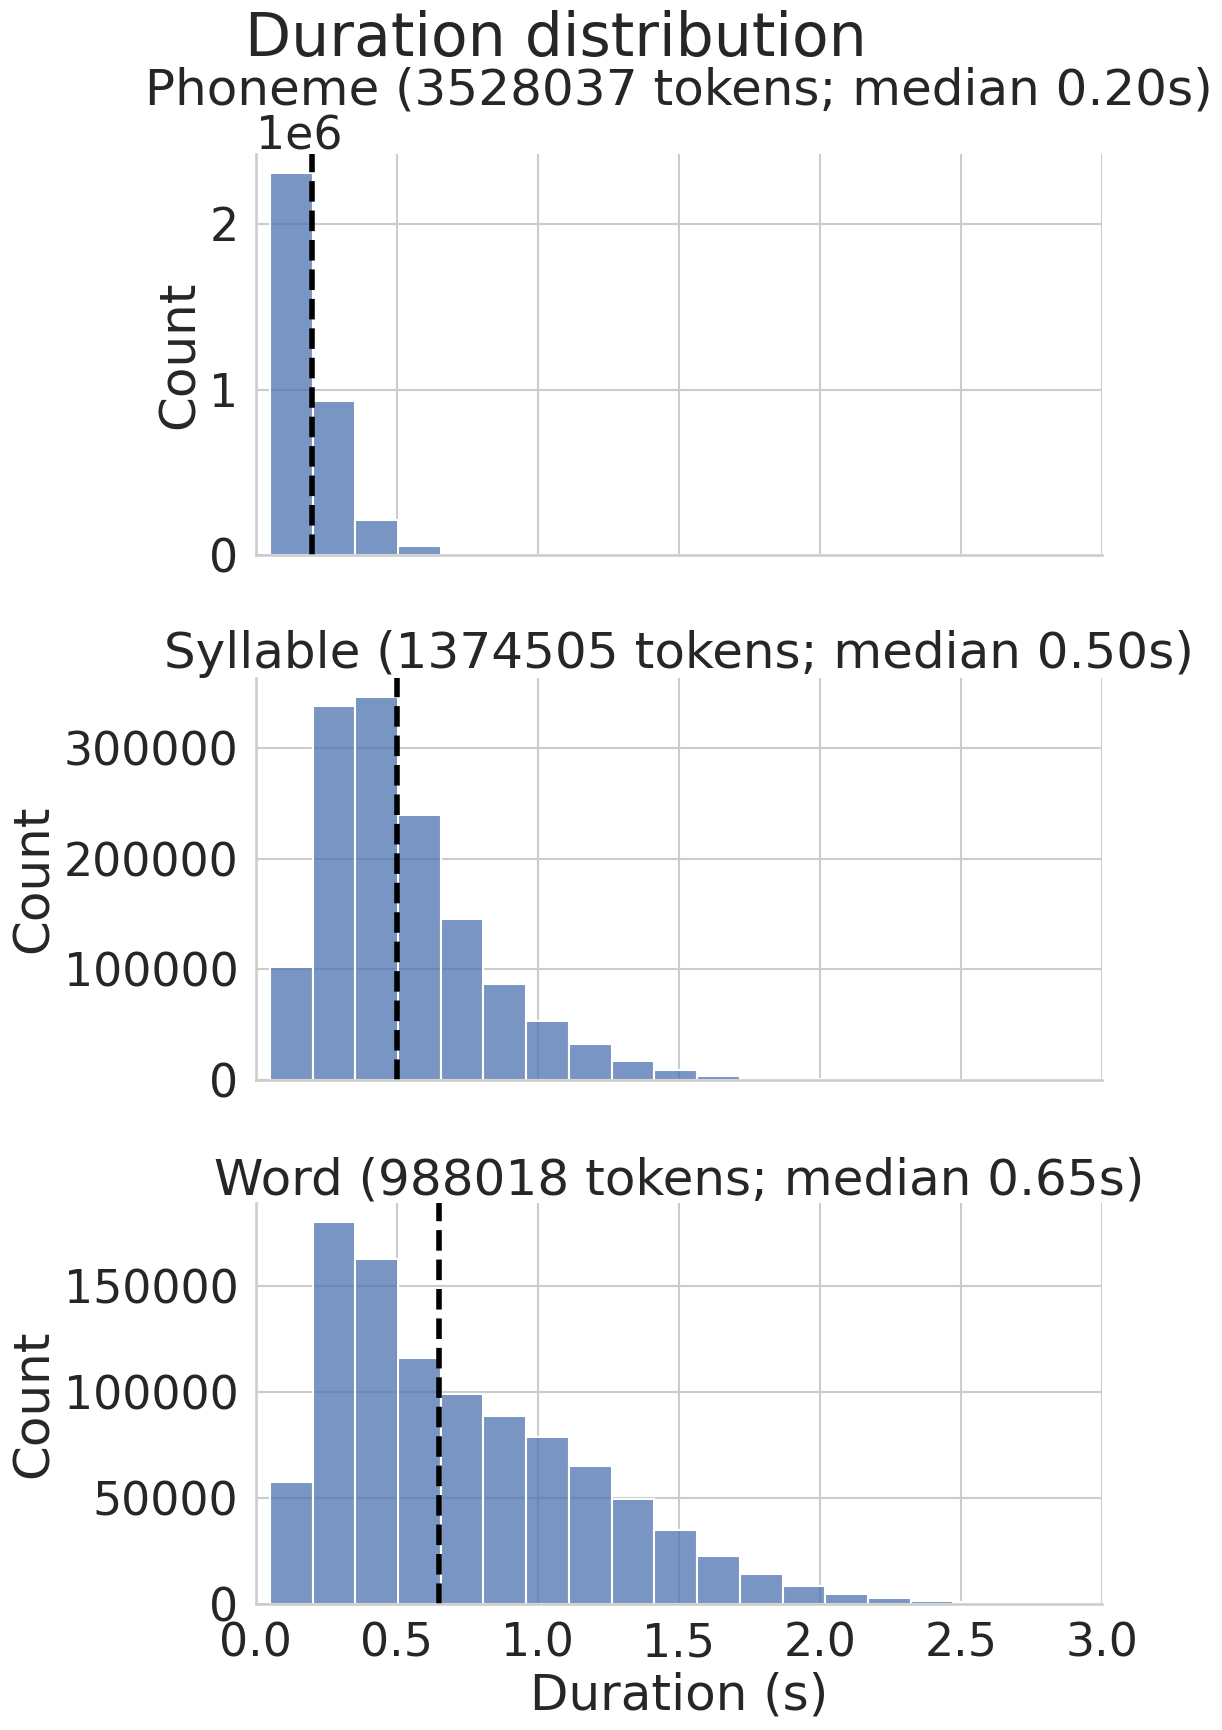

In [57]:
row_order = ["phoneme", "syllable", "word"]
g = sns.displot(
    lengths_df.reset_index(), x="duration", row="unit", row_order=row_order,
    binwidth=3 / 20, height=6, aspect=2, facet_kws=dict(sharey=False),
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Duration distribution")

for ax, unit in zip(g.axes.flat, row_order):
    median_length = lengths_df[lengths_df["unit"] == unit]["duration"].median()
    ax.set_title(f"{unit.capitalize()} ({len(lengths_df[lengths_df['unit'] == unit])} tokens; median {median_length:.2f}s)")
    ax.set_xlabel("Duration (s)")
    ax.set_ylabel("Count")
    ax.set_xlim((0, 3))

    print(unit, median_length)
    ax.axvline(median_length, color="black", linestyle="--", linewidth=4)

In [58]:
phoneme_in_word_df = word_trajectory_spec.cuts.xs("phoneme", level="level")
phoneme_in_word_df["idx_in_level"] = phoneme_in_word_df.groupby(["label", "instance_idx"]).cumcount()
phoneme_in_word_df["rev_idx_in_level"] = phoneme_in_word_df.groupby(["label", "instance_idx"]).cumcount(ascending=False)
phoneme_in_word_df

/tmp/ipykernel_2321267/54656410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phoneme_in_word_df["idx_in_level"] = phoneme_in_word_df.groupby(["label", "instance_idx"]).cumcount()
/tmp/ipykernel_2321267/54656410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phoneme_in_word_df["rev_idx_in_level"] = phoneme_in_word_df.groupby(["label", "instance_idx"]).cumcount(ascending=False)


description  onset_frame_idx  offset_frame_idx  item_idx  \
label   instance_idx                                                            
a       0                     AH              421               427         0   
        1                     AH              670               678         0   
        2                     AH              757               760         1   
        3                     AH             2315              2320         3   
        4                     EY             2375              2382         4   
...                          ...              ...               ...       ...   
zverkov 15                     V          9513329           9513335     15117   
        15                    ER          9513335           9513342     15117   
        15                     K          9513342           9513348     15117   
        15                    AO          9513348           9513355     15117   
        15                     V          9513355           9513386     15117   

                      idx_in_level  rev_idx_in_level  
label   instance_idx                                  
a       0                        0                 0  
        1                        0                 0  
        2                        0                 0  
        3                        0                 0  
        4                        0                 0  
...                            ...               ...  
zverkov 15                       1                 4  
        15                       2                 3  
        15                       3                 2  
        15                       4                 1  
        15                       5                 0  

[3528037 rows x 6 columns]

In [59]:
phoneme_in_syllable_df = syllable_trajectory_spec.cuts.xs("phoneme", level="level")
phoneme_in_syllable_df["idx_in_level"] = phoneme_in_syllable_df.groupby(["label", "instance_idx"]).cumcount()
phoneme_in_syllable_df["rev_idx_in_level"] = phoneme_in_syllable_df.groupby(["label", "instance_idx"]).cumcount(ascending=False)
phoneme_in_syllable_df

description  onset_frame_idx  offset_frame_idx  \
label    instance_idx                                                  
(AA,)    0                     AA            18787             18792   
         1                     AA            32003             32009   
         2                     AA            61143             61147   
         3                     AA            81569             81576   
         4                     AA           120598            120602   
...                           ...              ...               ...   
(ZH, UW) 109                   UW         17546203          17546208   
         110                   ZH         17630662          17630665   
         110                   UW         17630665          17630671   
         111                   ZH         17823684          17823688   
         111                   UW         17823688          17823691   

                       item_idx  idx_in_level  rev_idx_in_level  
label    instance_idx                                            
(AA,)    0                   32             0                 0  
         1                   55             0                 0  
         2                  101             0                 0  
         3                  133             0                 0  
         4                  191             0                 0  
...                         ...           ...               ...  
(ZH, UW) 109              27718             1                 0  
         110              27840             0                 1  
         110              27840             1                 0  
         111              28133             0                 1  
         111              28133             1                 0  

[3528037 rows x 6 columns]

In [60]:
phoneme_in_syllable_df[phoneme_in_syllable_df.idx_in_level == 6]

description  onset_frame_idx  \
label                  instance_idx                                
(G, L, IH, M, P, S, T) 0                      T          6866866   
                       1                      T         15990848   
(S, K, R, IH, P, T, S) 0                      S          1520378   
                       1                      S          3630891   
                       2                      S          8091676   
...                                         ...              ...   
(S, T, R, IH, K, T, S) 0                      S          1017030   
                       1                      S          1466239   
                       2                      S          6771232   
                       3                      S         14683598   
                       4                      S         15380781   

                                     offset_frame_idx  item_idx  idx_in_level  \
label                  instance_idx                                             
(G, L, IH, M, P, S, T) 0                      6866868     11002             6   
                       1                     15990853     25277             6   
(S, K, R, IH, P, T, S) 0                      1520382      2343             6   
                       1                      3630895      5730             6   
                       2                      8091681     12907             6   
...                                               ...       ...           ...   
(S, T, R, IH, K, T, S) 0                      1017039      1543             6   
                       1                      1466246      2231             6   
                       2                      6771235     10842             6   
                       3                     14683607     23252             6   
                       4                     15380790     24299             6   

                                     rev_idx_in_level  
label                  instance_idx                    
(G, L, IH, M, P, S, T) 0                            0  
                       1                            0  
(S, K, R, IH, P, T, S) 0                            0  
                       1                            0  
                       2                            0  
...                                               ...  
(S, T, R, IH, K, T, S) 0                            0  
                       1                            0  
                       2                            0  
                       3                            0  
                       4                            0  

[122 rows x 6 columns]

In [61]:
# Phoneme stats

# mean onset of each phoneme relative to syllable start
phoneme_in_syllable_df["relative_onset"] = phoneme_in_syllable_df.onset_frame_idx - phoneme_in_syllable_df.groupby(["label", "instance_idx"]).onset_frame_idx.min()
phoneme_in_syllable_mean_onsets = phoneme_in_syllable_df.groupby("idx_in_level").relative_onset.mean() / 20
phoneme_in_word_df["relative_onset"] = phoneme_in_word_df.onset_frame_idx - phoneme_in_word_df.groupby(["label", "instance_idx"]).onset_frame_idx.min()
phoneme_in_word_mean_onsets = phoneme_in_word_df.groupby("idx_in_level").relative_onset.mean() / 20

# mean onset of each phoneme indexed from end, relative to end
phoneme_in_syllable_df["reverse_relative_onset"] = phoneme_in_syllable_df.onset_frame_idx - phoneme_in_syllable_df.groupby(["label", "instance_idx"]).offset_frame_idx.max()
phoneme_in_syllable_reverse_mean_onsets = -phoneme_in_syllable_df.groupby("rev_idx_in_level").reverse_relative_onset.mean() / 20
phoneme_in_word_df["reverse_relative_onset"] = phoneme_in_word_df.onset_frame_idx - phoneme_in_word_df.groupby(["label", "instance_idx"]).offset_frame_idx.max()
phoneme_in_word_reverse_mean_onsets = -phoneme_in_word_df.groupby("rev_idx_in_level").reverse_relative_onset.mean() / 20
phoneme_in_word_reverse_mean_onsets

/tmp/ipykernel_2321267/3890120054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phoneme_in_word_df["relative_onset"] = phoneme_in_word_df.onset_frame_idx - phoneme_in_word_df.groupby(["label", "instance_idx"]).onset_frame_idx.min()
/tmp/ipykernel_2321267/3890120054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phoneme_in_word_df["reverse_relative_onset"] = phoneme_in_word_df.onset_frame_idx - phoneme_in_word_df.groupby(["label", "instance_idx"]).offset_frame_idx.max()


rev_idx_in_level
0     0.222872
1     0.421764
2     0.640682
3     0.854317
4     1.018703
5     1.186405
6     1.344893
7     1.500379
8     1.651791
9     1.821176
10    1.968031
11    2.128185
12    2.290672
13    2.480372
14    2.687500
15    2.808824
16    3.000000
Name: reverse_relative_onset, dtype: float64

In [62]:
# equiv_dataset = torch.load(equiv_dataset_path)

# Coherence analyses

In [63]:
def truncate_contrasts(distance_df, min_contrast_instances=50) -> pd.DataFrame:
    # We want to make comparisons between contrasts only when we have enough data
    # between individual units in the contrast to have a meaningful mean.
    # e.g. if a "within" contrast at frame 5 only has 2 instances, it's not so informative to compare this mean to the "between" contrast at frame 5.

    # Find the maximum frame at which, for all contrasts, we have at least `min_contrast_instances` instances
    # underlying each contrast value.
    max_contrast_frame = distance_df.groupby(["model", "equivalence", "frame"]) \
        .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \
        .groupby(["model", "equivalence"]).idxmax().str[-1].min()
    
    return distance_df[distance_df.frame < max_contrast_frame]

In [64]:
xs = []
def load_grouped_distances(glob, plot_model_names=None, min_contrast_instances=50):
    syll_onset_paths = list(Path("outputs/notebooks").glob(glob))
    if plot_model_names is None:
        plot_model_names = plot_models.keys()
    model_key_to_name = {key: name for name, key in plot_models.items()
                         if name in plot_model_names}

    dfs = {}
    for path in syll_onset_paths:
        dataset, base_model, model_class, equivalence = path.parts[-6:-2]
        if model_class.startswith("random"):
            model_class = model_class[len("random"):]
        
        key = (dataset, base_model, model_class, equivalence)
        if key in model_key_to_name:
            name = model_key_to_name[key]
            dfs[(name,) + key] = pd.read_csv(path)

    df = pd.concat(dfs, names=["name", "dataset", "base_model", "model", "equivalence"])
    xs.append(xs)
    df = truncate_contrasts(df, min_contrast_instances=min_contrast_instances)

    return df

In [65]:
def plot_coherence(coherence_df, unit, alignment="onset", col="equivalence",
                   plot_phonemes=None, sharex=True, legend=False, plot_kwargs=None, **kwargs):
    coherence_df = coherence_df.reset_index()
    coherence_df["equivalence"] = coherence_df.equivalence.str.capitalize()

    default_kwargs = dict(col_wrap=2)
    kwargs = {**default_kwargs, **kwargs}
    col_order = [e.capitalize() for e in plot_equivalences] if col == "equivalence" else None
    g = sns.FacetGrid(data=coherence_df, col=col, col_order=col_order,
                      sharex=sharex, sharey=True, height=8, aspect=2, **kwargs)
    g.map(sns.lineplot, "time", "distance", "type", **(plot_kwargs or {}))

    if legend:
        g.add_legend()
    g.set_titles(template="{col_name}")

    for ax in g.axes.flat:
        ax.grid(False)
        ax.set_ylim((-0.2, 1.2))
        ax.axhline(0, color="gray", linestyle="--", alpha=0.8)
        ax.axhline(1, color="gray", linestyle="--", alpha=0.8)
        ax.set_ylabel("Cosine distance")

        if alignment == "onset":
            ax.set_xlim((-.065, ax.get_xlim()[1]))
            ax.set_xlabel(f"Time since {unit} onset (s)")
            ax.axvline(0, color="gray", linestyle="--", linewidth=4)
            ymin, ymax = ax.get_ylim()
            ax.text(0, (ymax - ymin) / 3, f"{unit.capitalize()} onset", color="gray",
                    rotation=90, ha="right", va="center",
                    fontsize="large", fontweight="bold")
        elif alignment == "offset":
            ax.set_xlabel(f"Time until {unit} offset (s)")
            ax.axvline(0, color="gray", linestyle="--", linewidth=4)
            ymin, ymax = ax.get_ylim()
            ax.text(-0.05, (ymax - ymin) / 3, f"{unit.capitalize()} offset", color="gray",
                    rotation=90, ha="left", va="center",
                    fontsize="large", fontweight="bold")

        if plot_phonemes is not None:
            xmin, xmax = ax.get_xlim()
            for phoneme_onset in plot_phonemes:
                if phoneme_onset < xmax:
                    ax.axvline(phoneme_onset, color="salmon", linestyle="--", alpha=0.5)

    if alignment == "offset":
        if sharex:
            # will apply to all
            g.axes.flat[0].invert_xaxis()
        else:
            for ax in g.axes.flat:
                ax.invert_xaxis()

    return g

## Phoneme-level coherence

In [66]:
phoneme_distance_by_position_df = load_grouped_distances(
    f"**/phoneme_coherence_by_position/distances.csv", min_contrast_instances=10)
phoneme_distance_by_position_df["time"] = phoneme_distance_by_position_df["frame"] / 20

/tmp/ipykernel_2321267/2152939426.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \


/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


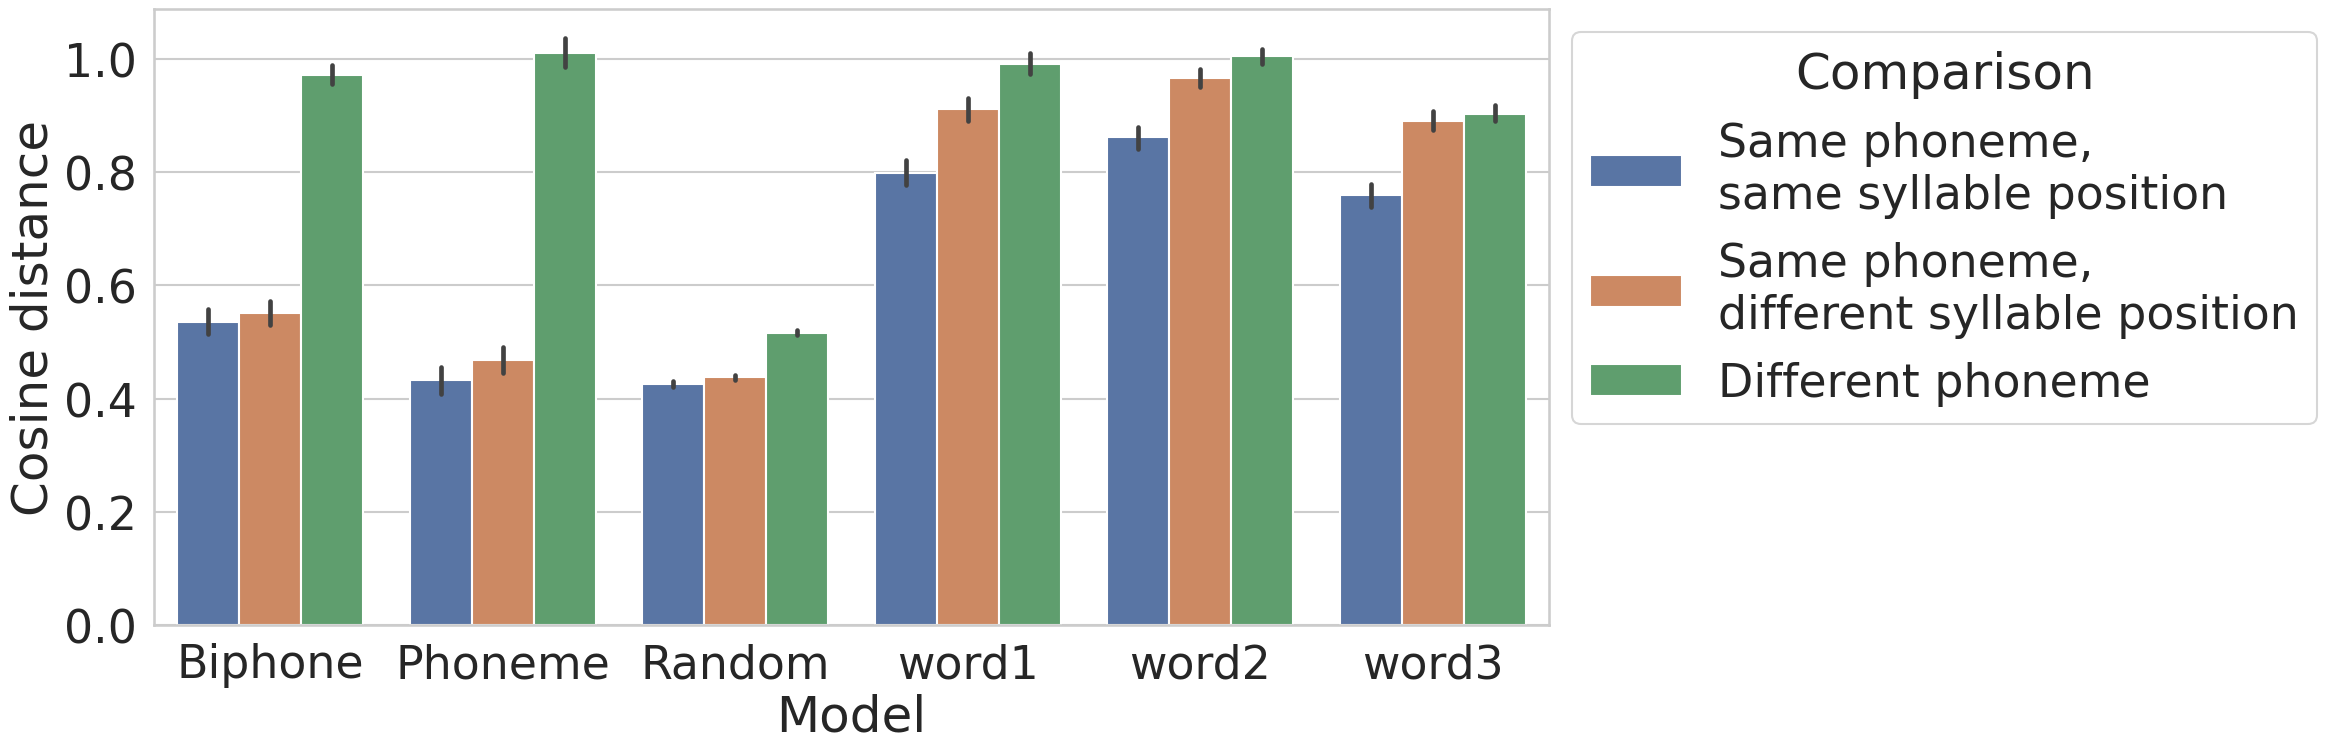

In [67]:
f, ax = plt.subplots(figsize=(18, 8))
phoneme_plot_data = phoneme_distance_by_position_df.reset_index()
phoneme_plot_data["type"] = phoneme_plot_data["type"].map(
    {"within": "Same phoneme,\nsame syllable position",
     "different_position": "Same phoneme,\ndifferent syllable position",
     "between": "Different phoneme"}
)
sns.barplot(data=phoneme_plot_data,
            x="name", y="distance", hue="type", ax=ax)

ax.set_ylabel("Cosine distance")
ax.set_xlabel("Model")
ax.legend(title="Comparison", loc="upper left", bbox_to_anchor=(1, 1))

### By phoneme category

In [68]:
phoneme_distance_by_cv_df = load_grouped_distances(
    "**/phoneme_coherence/grouped_distances.csv")#, plot_model_classes, plot_equivalences)
phoneme_distance_by_cv_df["time"] = phoneme_distance_by_cv_df["frame"] / 20

/tmp/ipykernel_2321267/2152939426.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \


/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


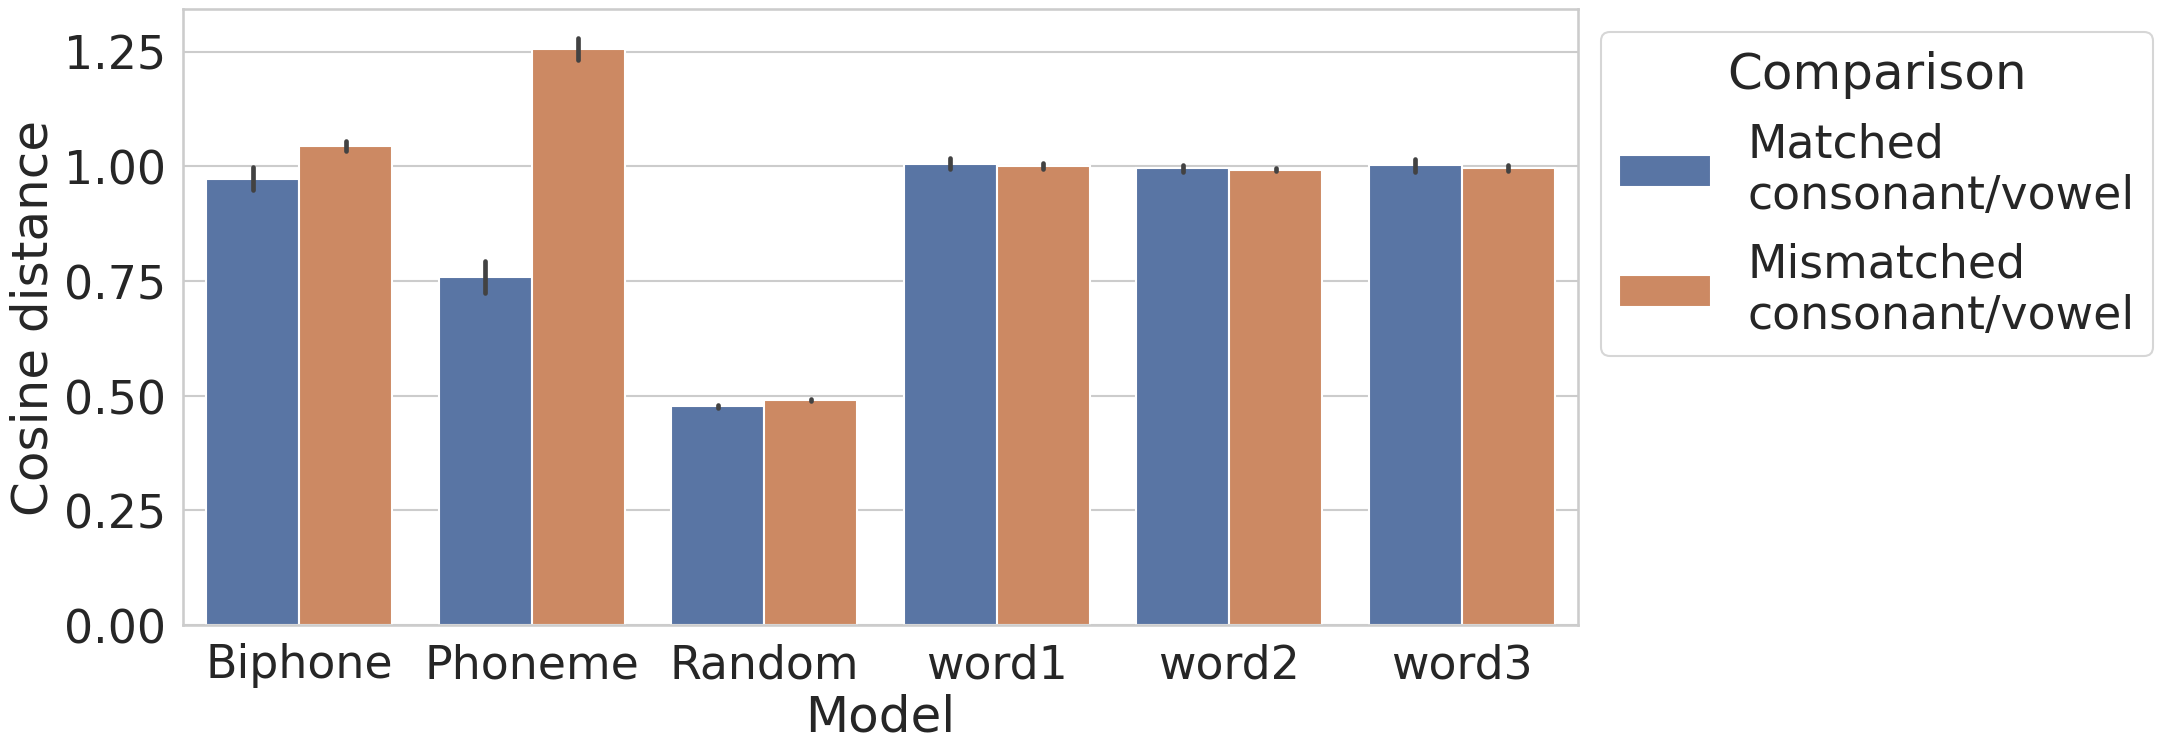

In [69]:
f, ax = plt.subplots(figsize=(18, 8))
phoneme_plot_data = phoneme_distance_by_cv_df.reset_index()
phoneme_plot_data["type"] = phoneme_plot_data["type"].map(
    {"within": "Matched\nconsonant/vowel",
     "between": "Mismatched\nconsonant/vowel"}
)
sns.barplot(data=phoneme_plot_data,
            x="name", y="distance", hue="type", ax=ax)

ax.set_ylabel("Cosine distance")
ax.set_xlabel("Model")
ax.legend(title="Comparison", loc="upper left", bbox_to_anchor=(1, 1))

## Syllable-level coherence

In [70]:
syll_distance_by_position_df = load_grouped_distances("**/syllable_coherence_by_position/distances.csv", min_contrast_instances=100)

/tmp/ipykernel_2321267/2152939426.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \


In [71]:
syll_distance_by_position_df["syllable_position"] = syll_distance_by_position_df.syllable.str.split(" ").str[-1].astype(int)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


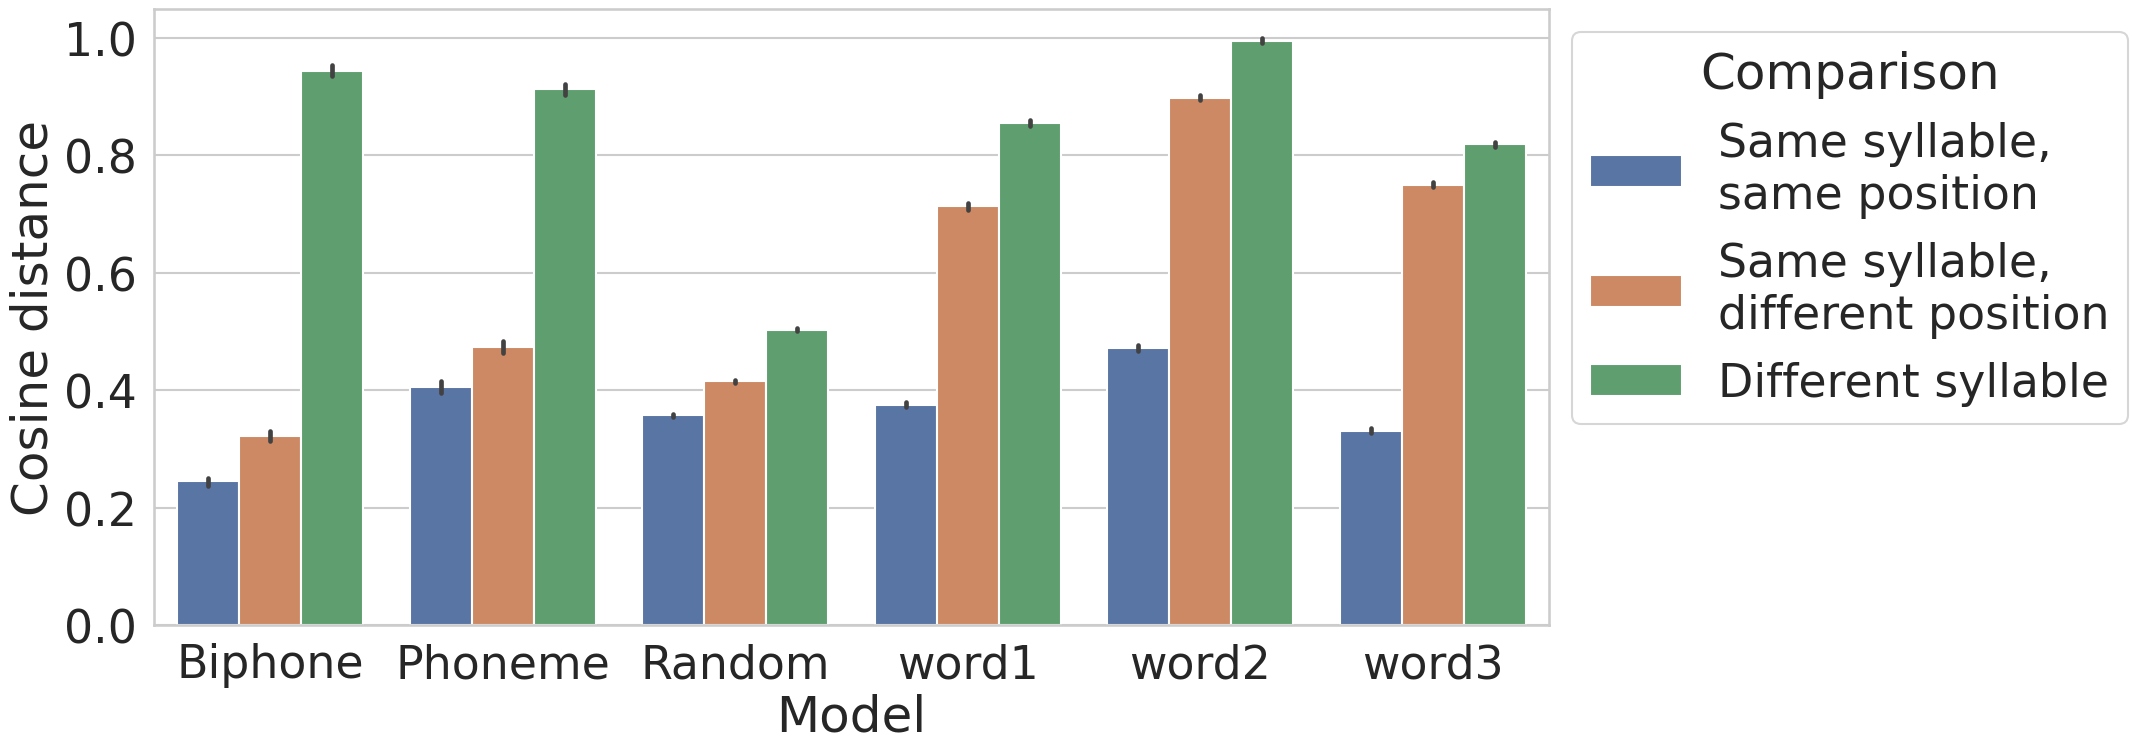

In [72]:
f, ax = plt.subplots(figsize=(18, 8))
syllable_plot_data = syll_distance_by_position_df.reset_index()
syllable_plot_data["type"] = syllable_plot_data["type"].map(
    {"within": "Same syllable,\nsame position",
     "different_position": "Same syllable,\ndifferent position",
     "between": "Different syllable"}
)
sns.barplot(data=syllable_plot_data,#[syllable_plot_data.syllable_position],
            x="name", y="distance", hue="type", ax=ax)

ax.set_ylabel("Cosine distance")
ax.set_xlabel("Model")
ax.legend(title="Comparison", loc="upper left", bbox_to_anchor=(1, 1))

### Grouped by onset

In [73]:
syll_onset_distance_df = load_grouped_distances("**/syllable_coherence/distances-grouped_onset.csv")
syll_onset_distance_align_offset_df = load_grouped_distances("**/syllable_coherence/distances-grouped_onset_aligned_offset.csv")

/tmp/ipykernel_2321267/2152939426.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \
/tmp/ipykernel_2321267/2152939426.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \


/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

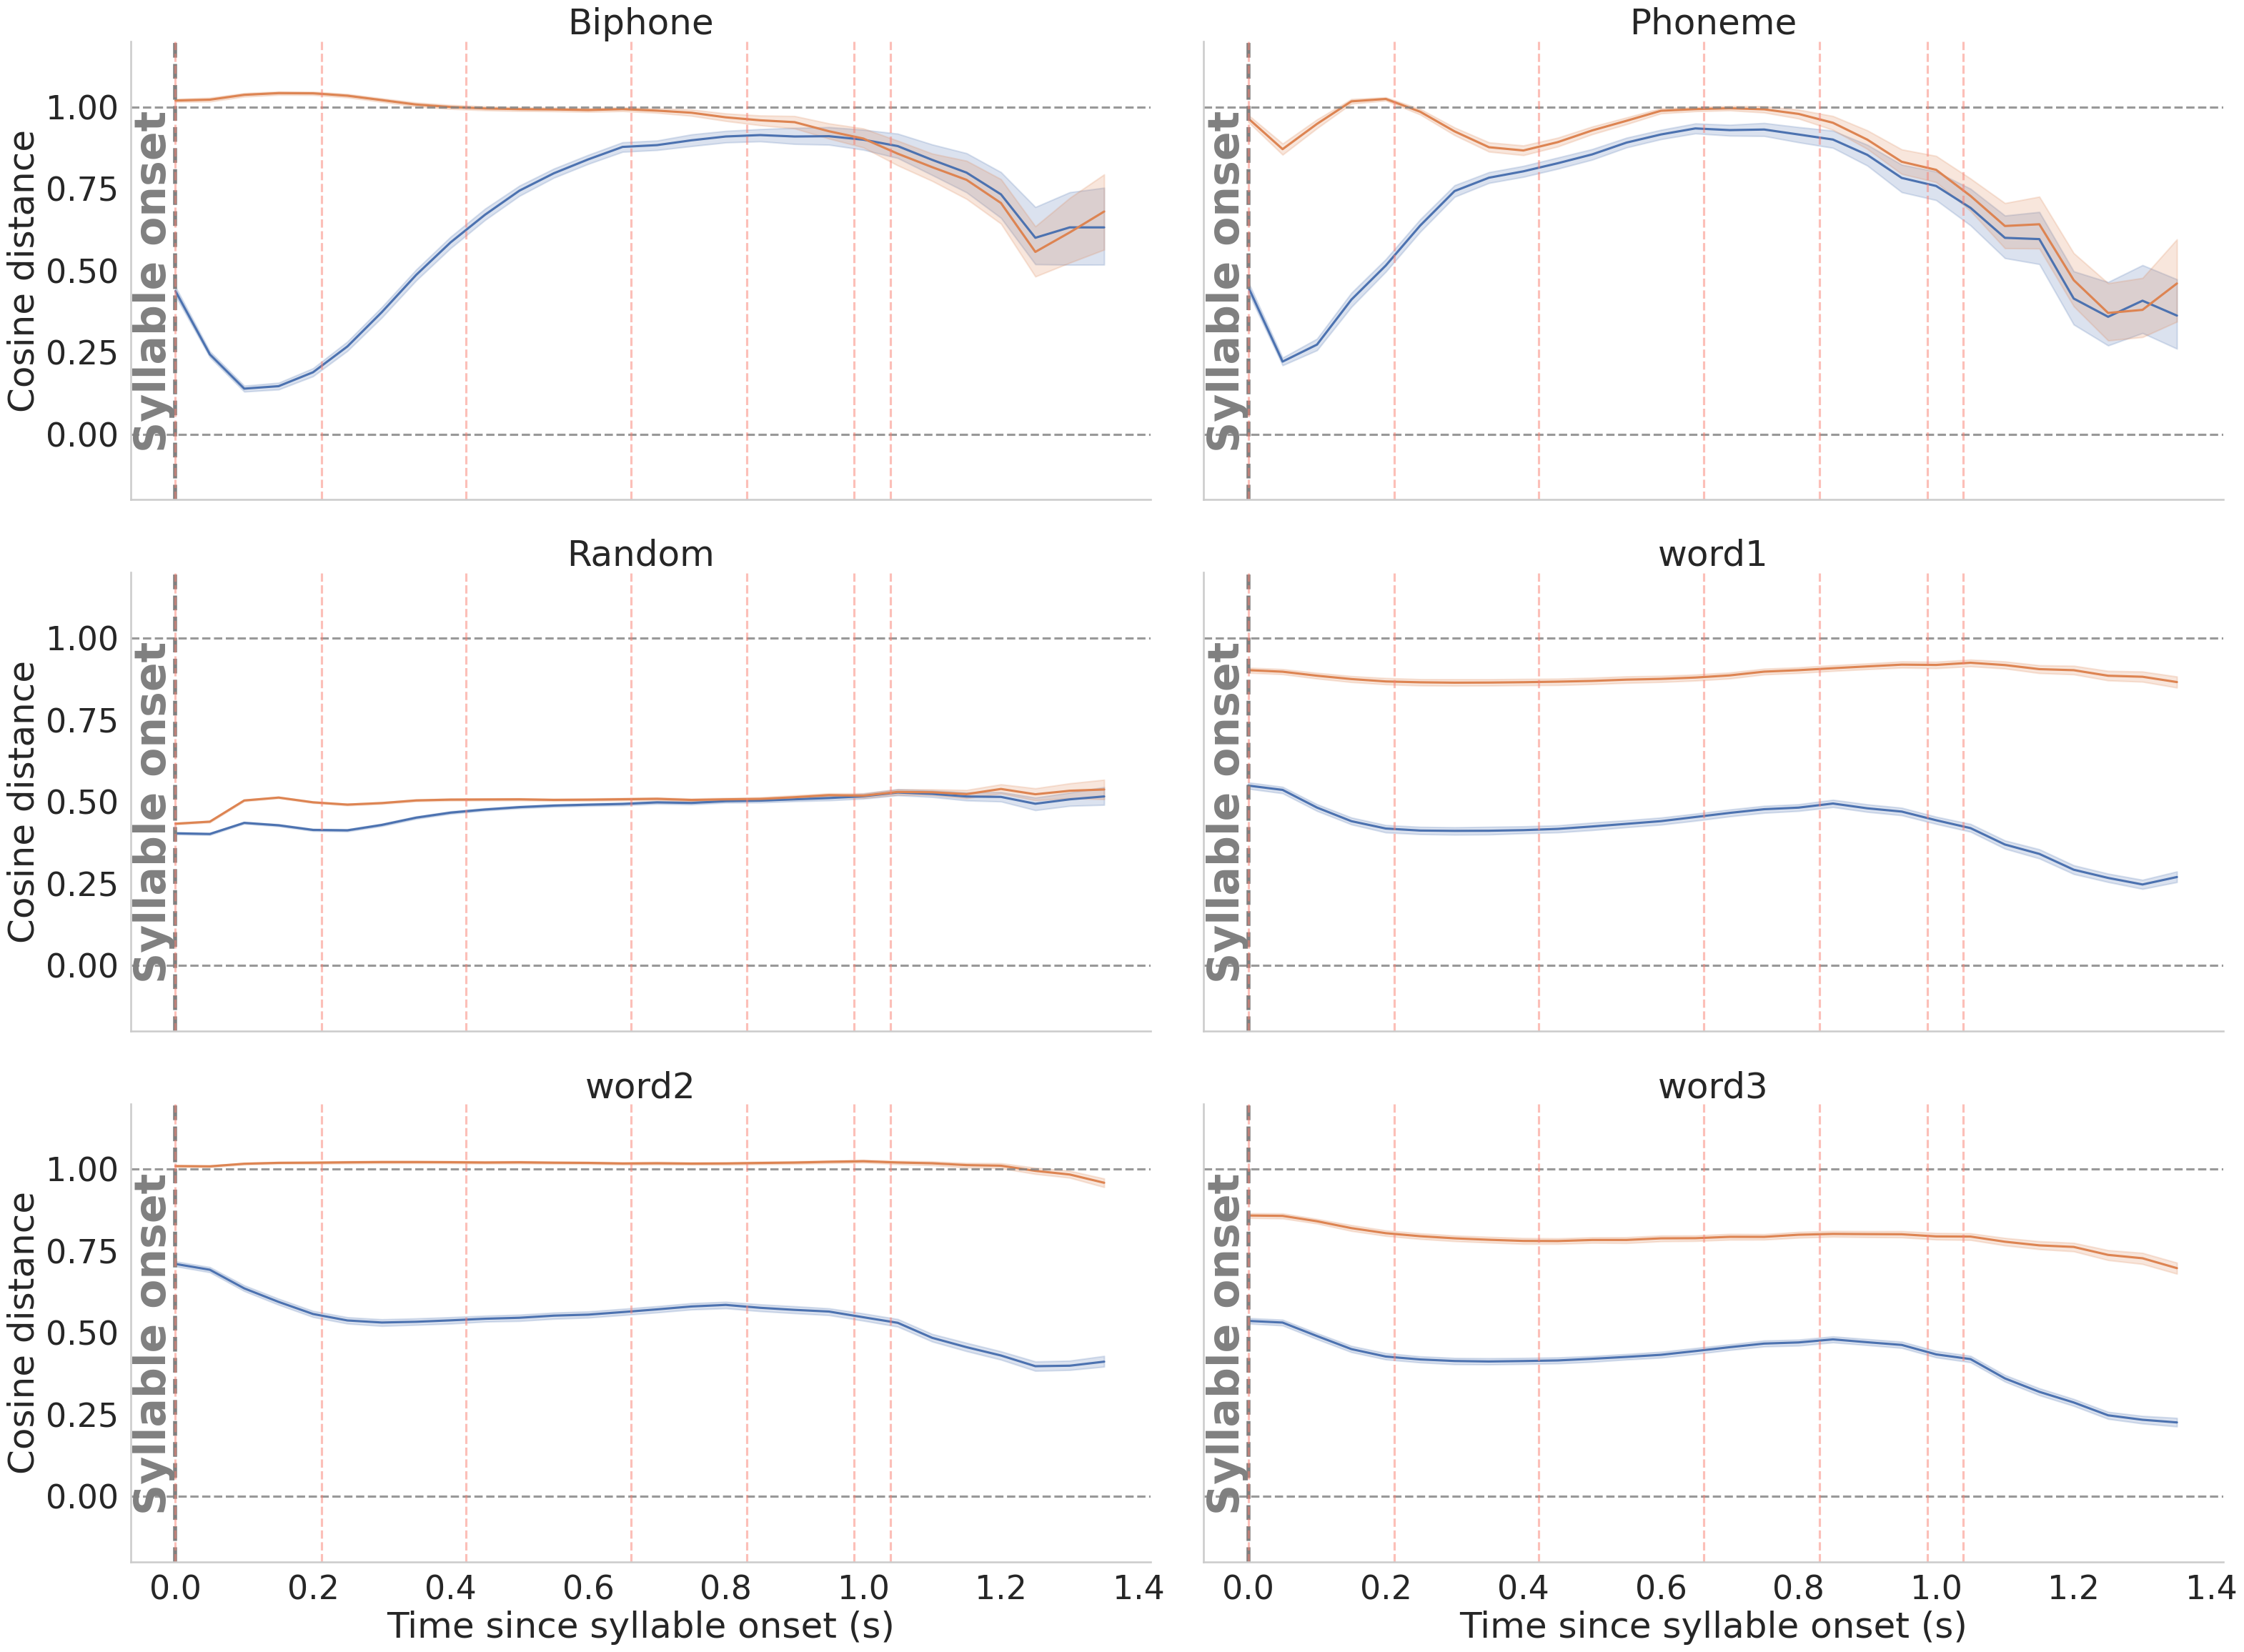

In [74]:
g = plot_coherence(syll_onset_distance_df, "syllable", col="name",
                   plot_phonemes=phoneme_in_syllable_mean_onsets)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

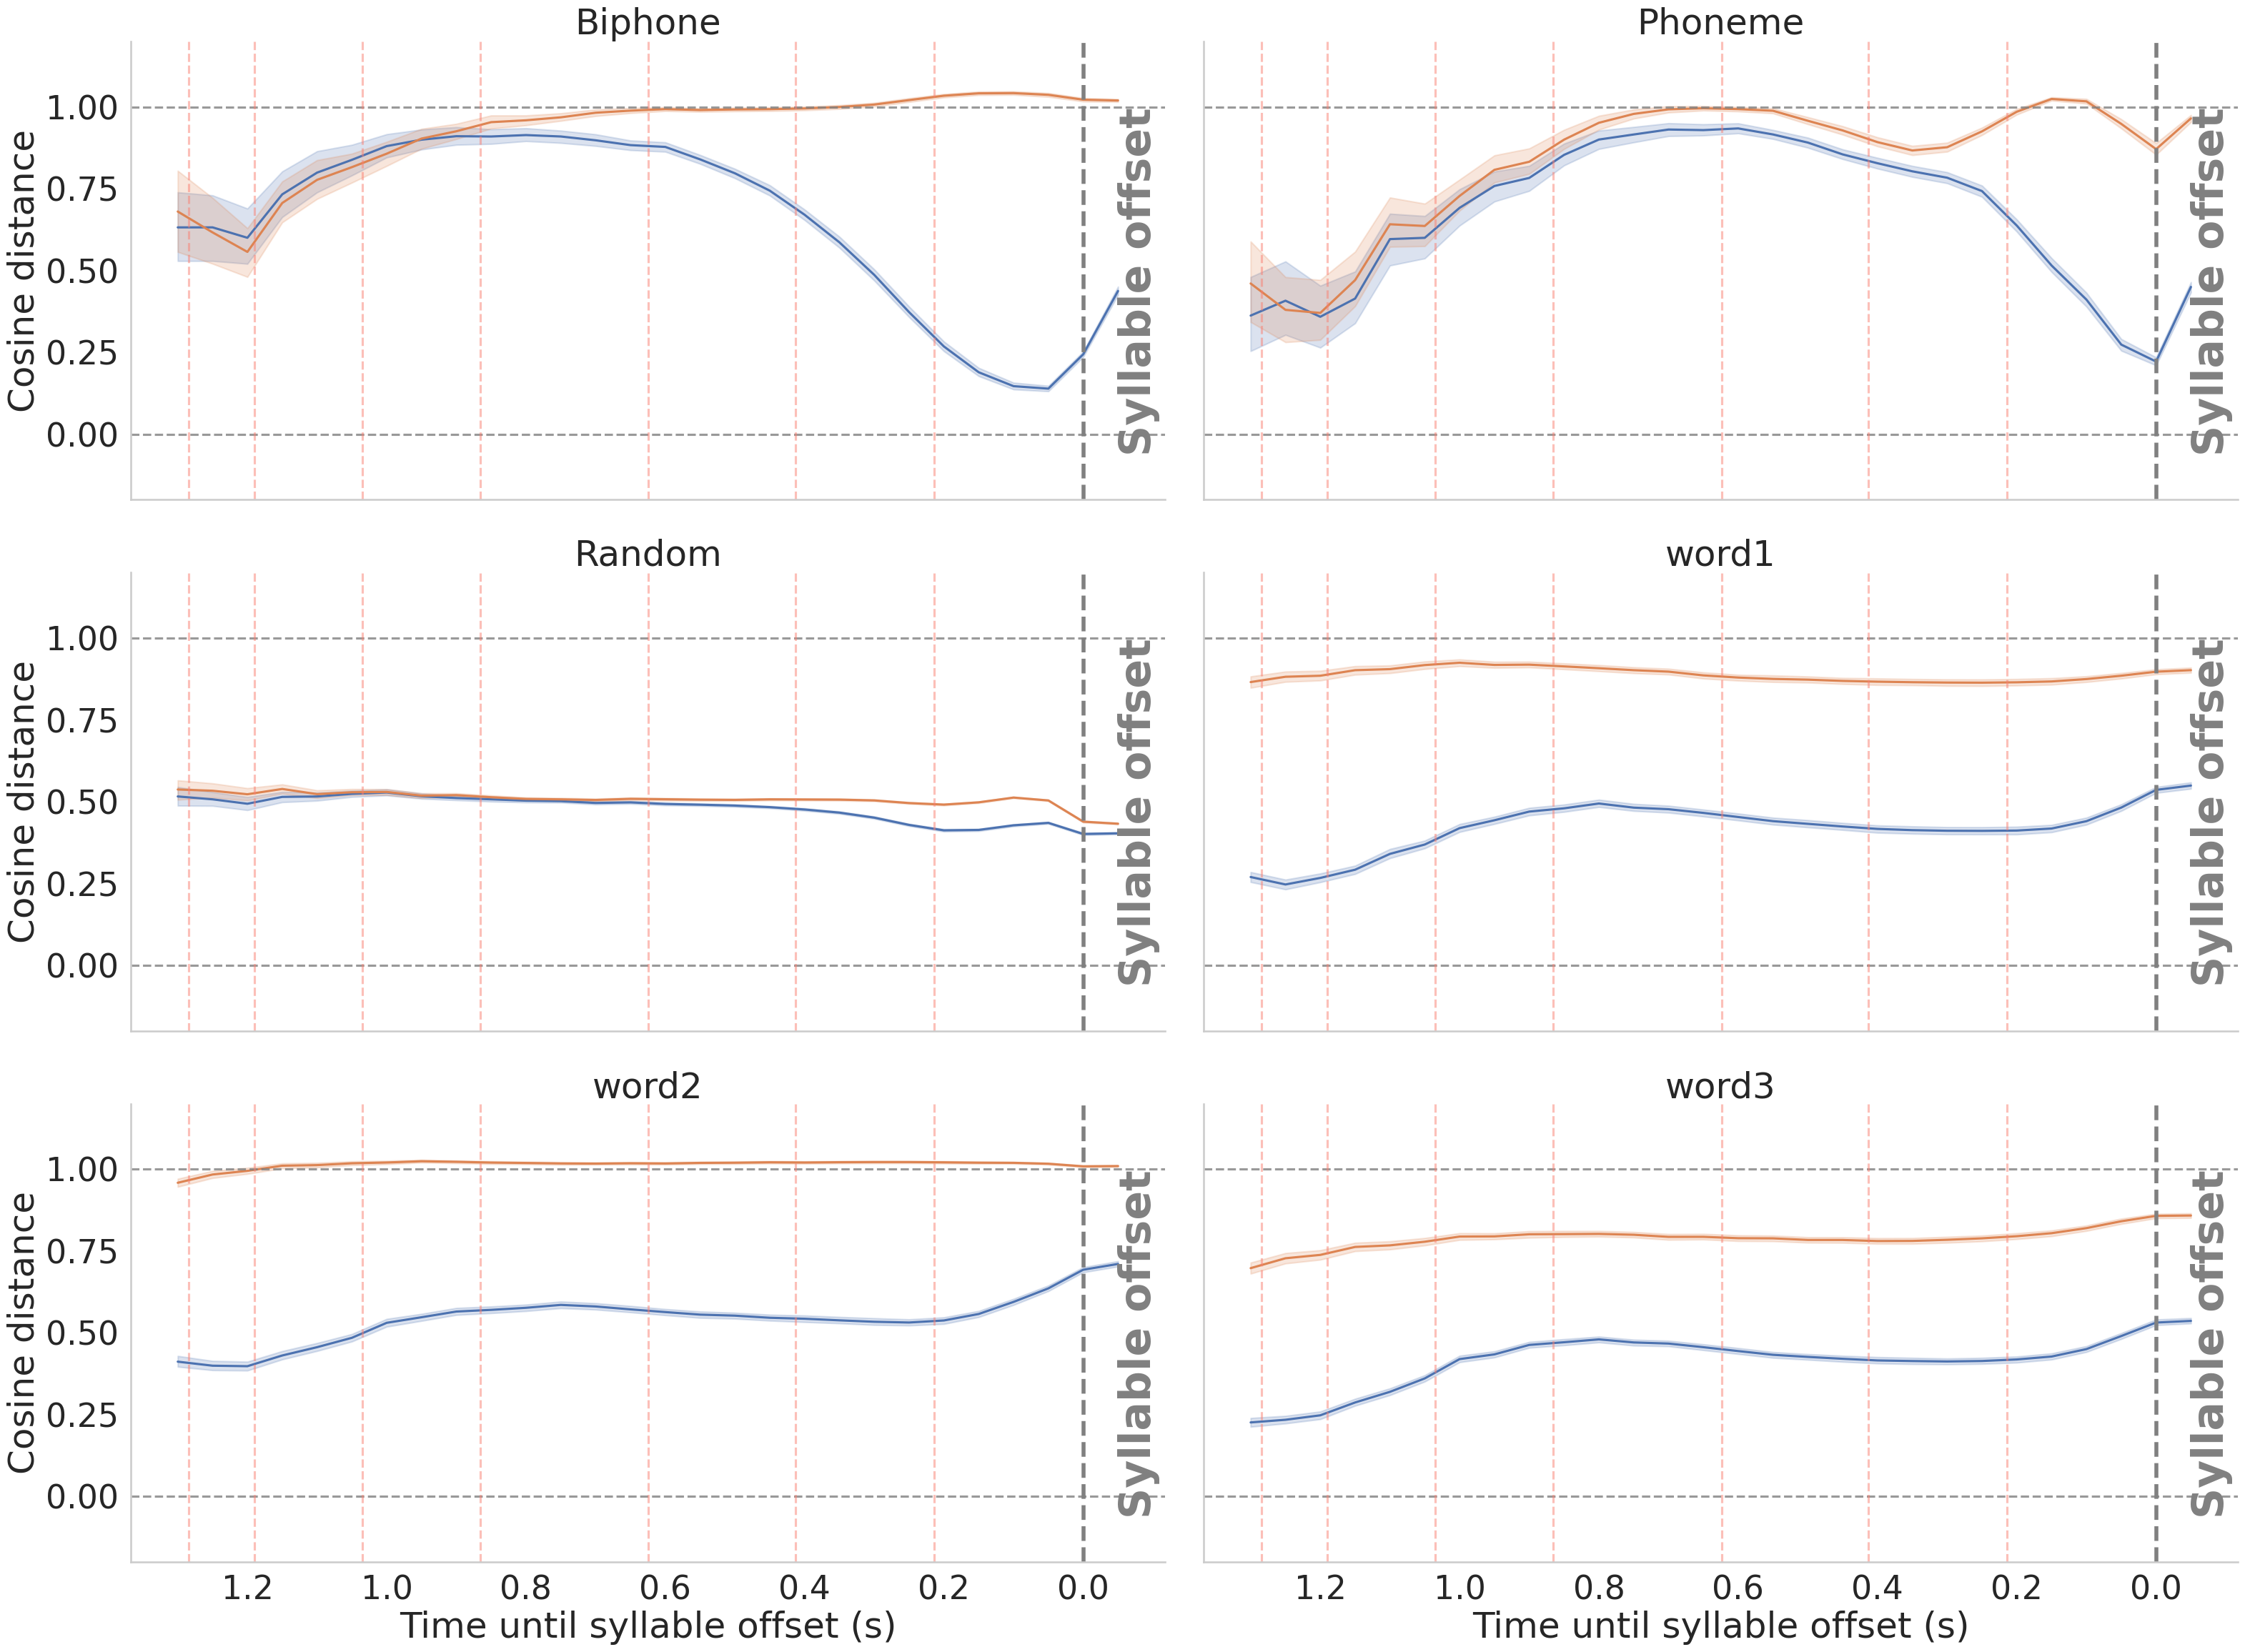

In [75]:
g = plot_coherence(syll_onset_distance_align_offset_df, "syllable", alignment="offset", col="name",
                   plot_phonemes=phoneme_in_syllable_reverse_mean_onsets)

### Grouped by nucleus

In [76]:
syll_nucleus_distance_df = load_grouped_distances("**/syllable_coherence/distances-grouped_nucleus.csv")
syll_nucleus_distance_align_offset_df = load_grouped_distances("**/syllable_coherence/distances-grouped_nucleus_aligned_offset.csv")

/tmp/ipykernel_2321267/2152939426.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \
/tmp/ipykernel_2321267/2152939426.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \


In [77]:
syll_nucleus_distance_align_offset_df.loc["word2"].groupby("label").frame.max().min()

27

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

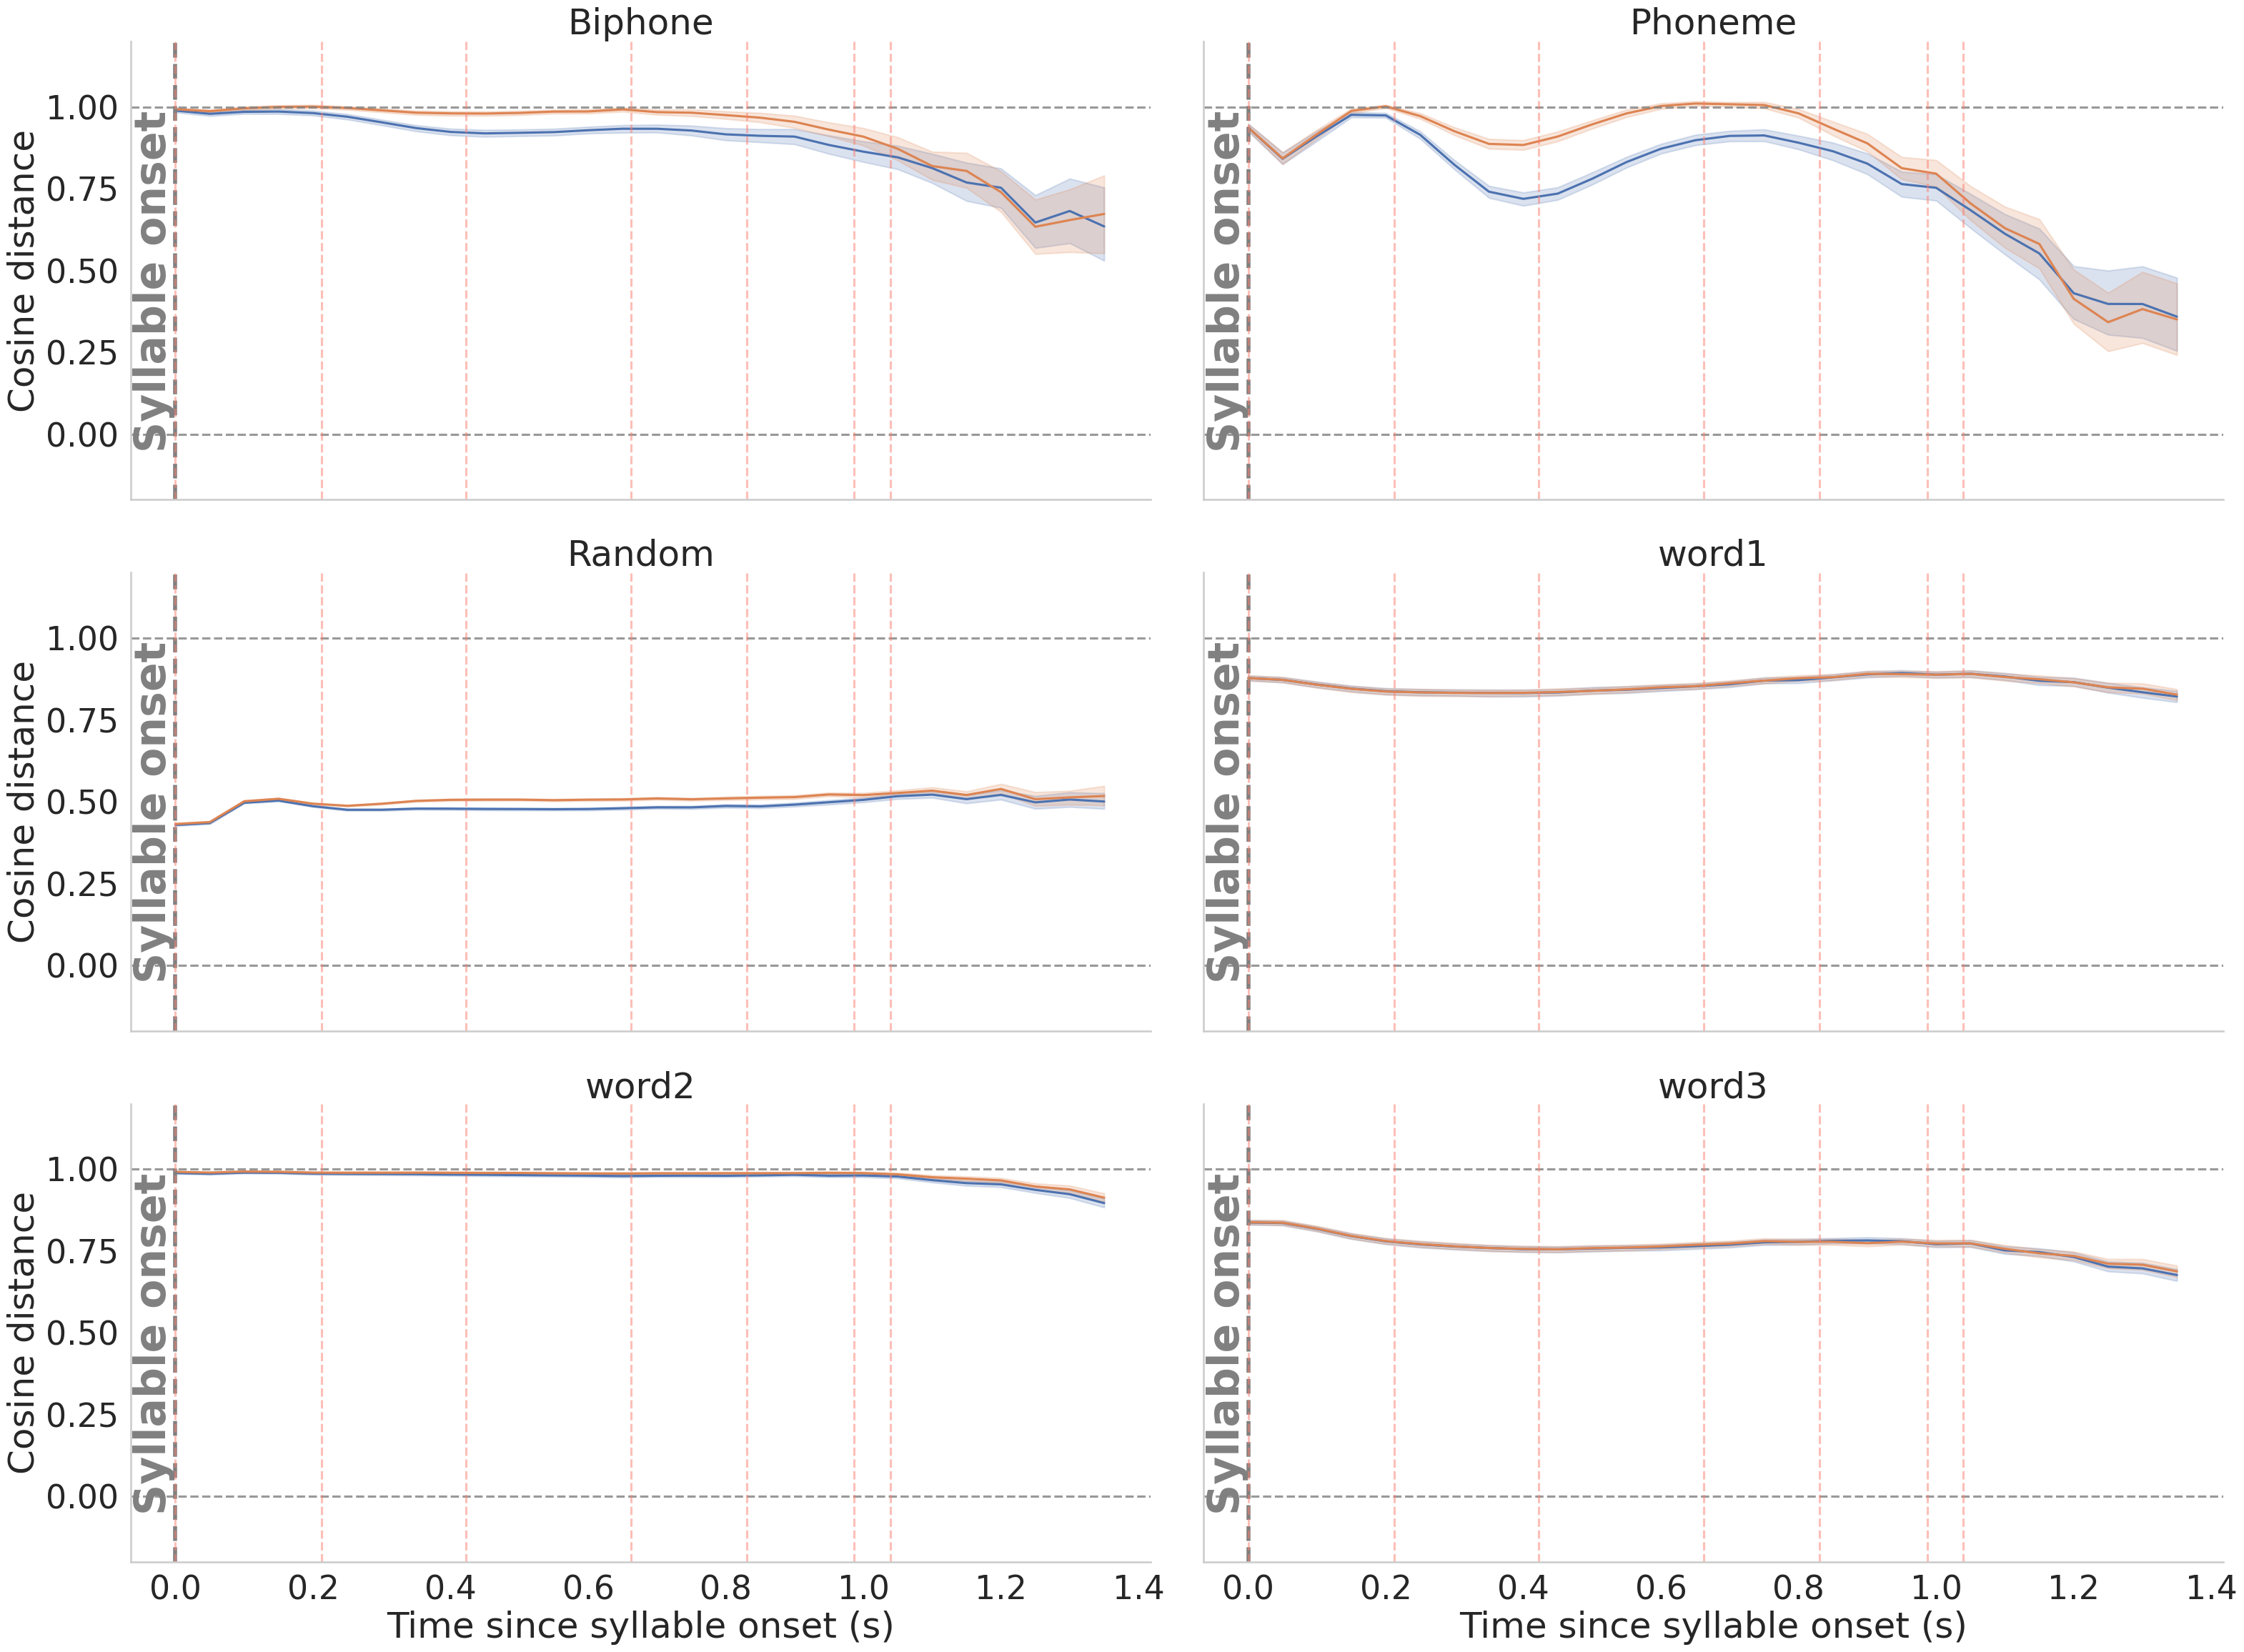

In [78]:
plot_coherence(syll_nucleus_distance_df, "syllable", col="name", plot_phonemes=phoneme_in_syllable_mean_onsets)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

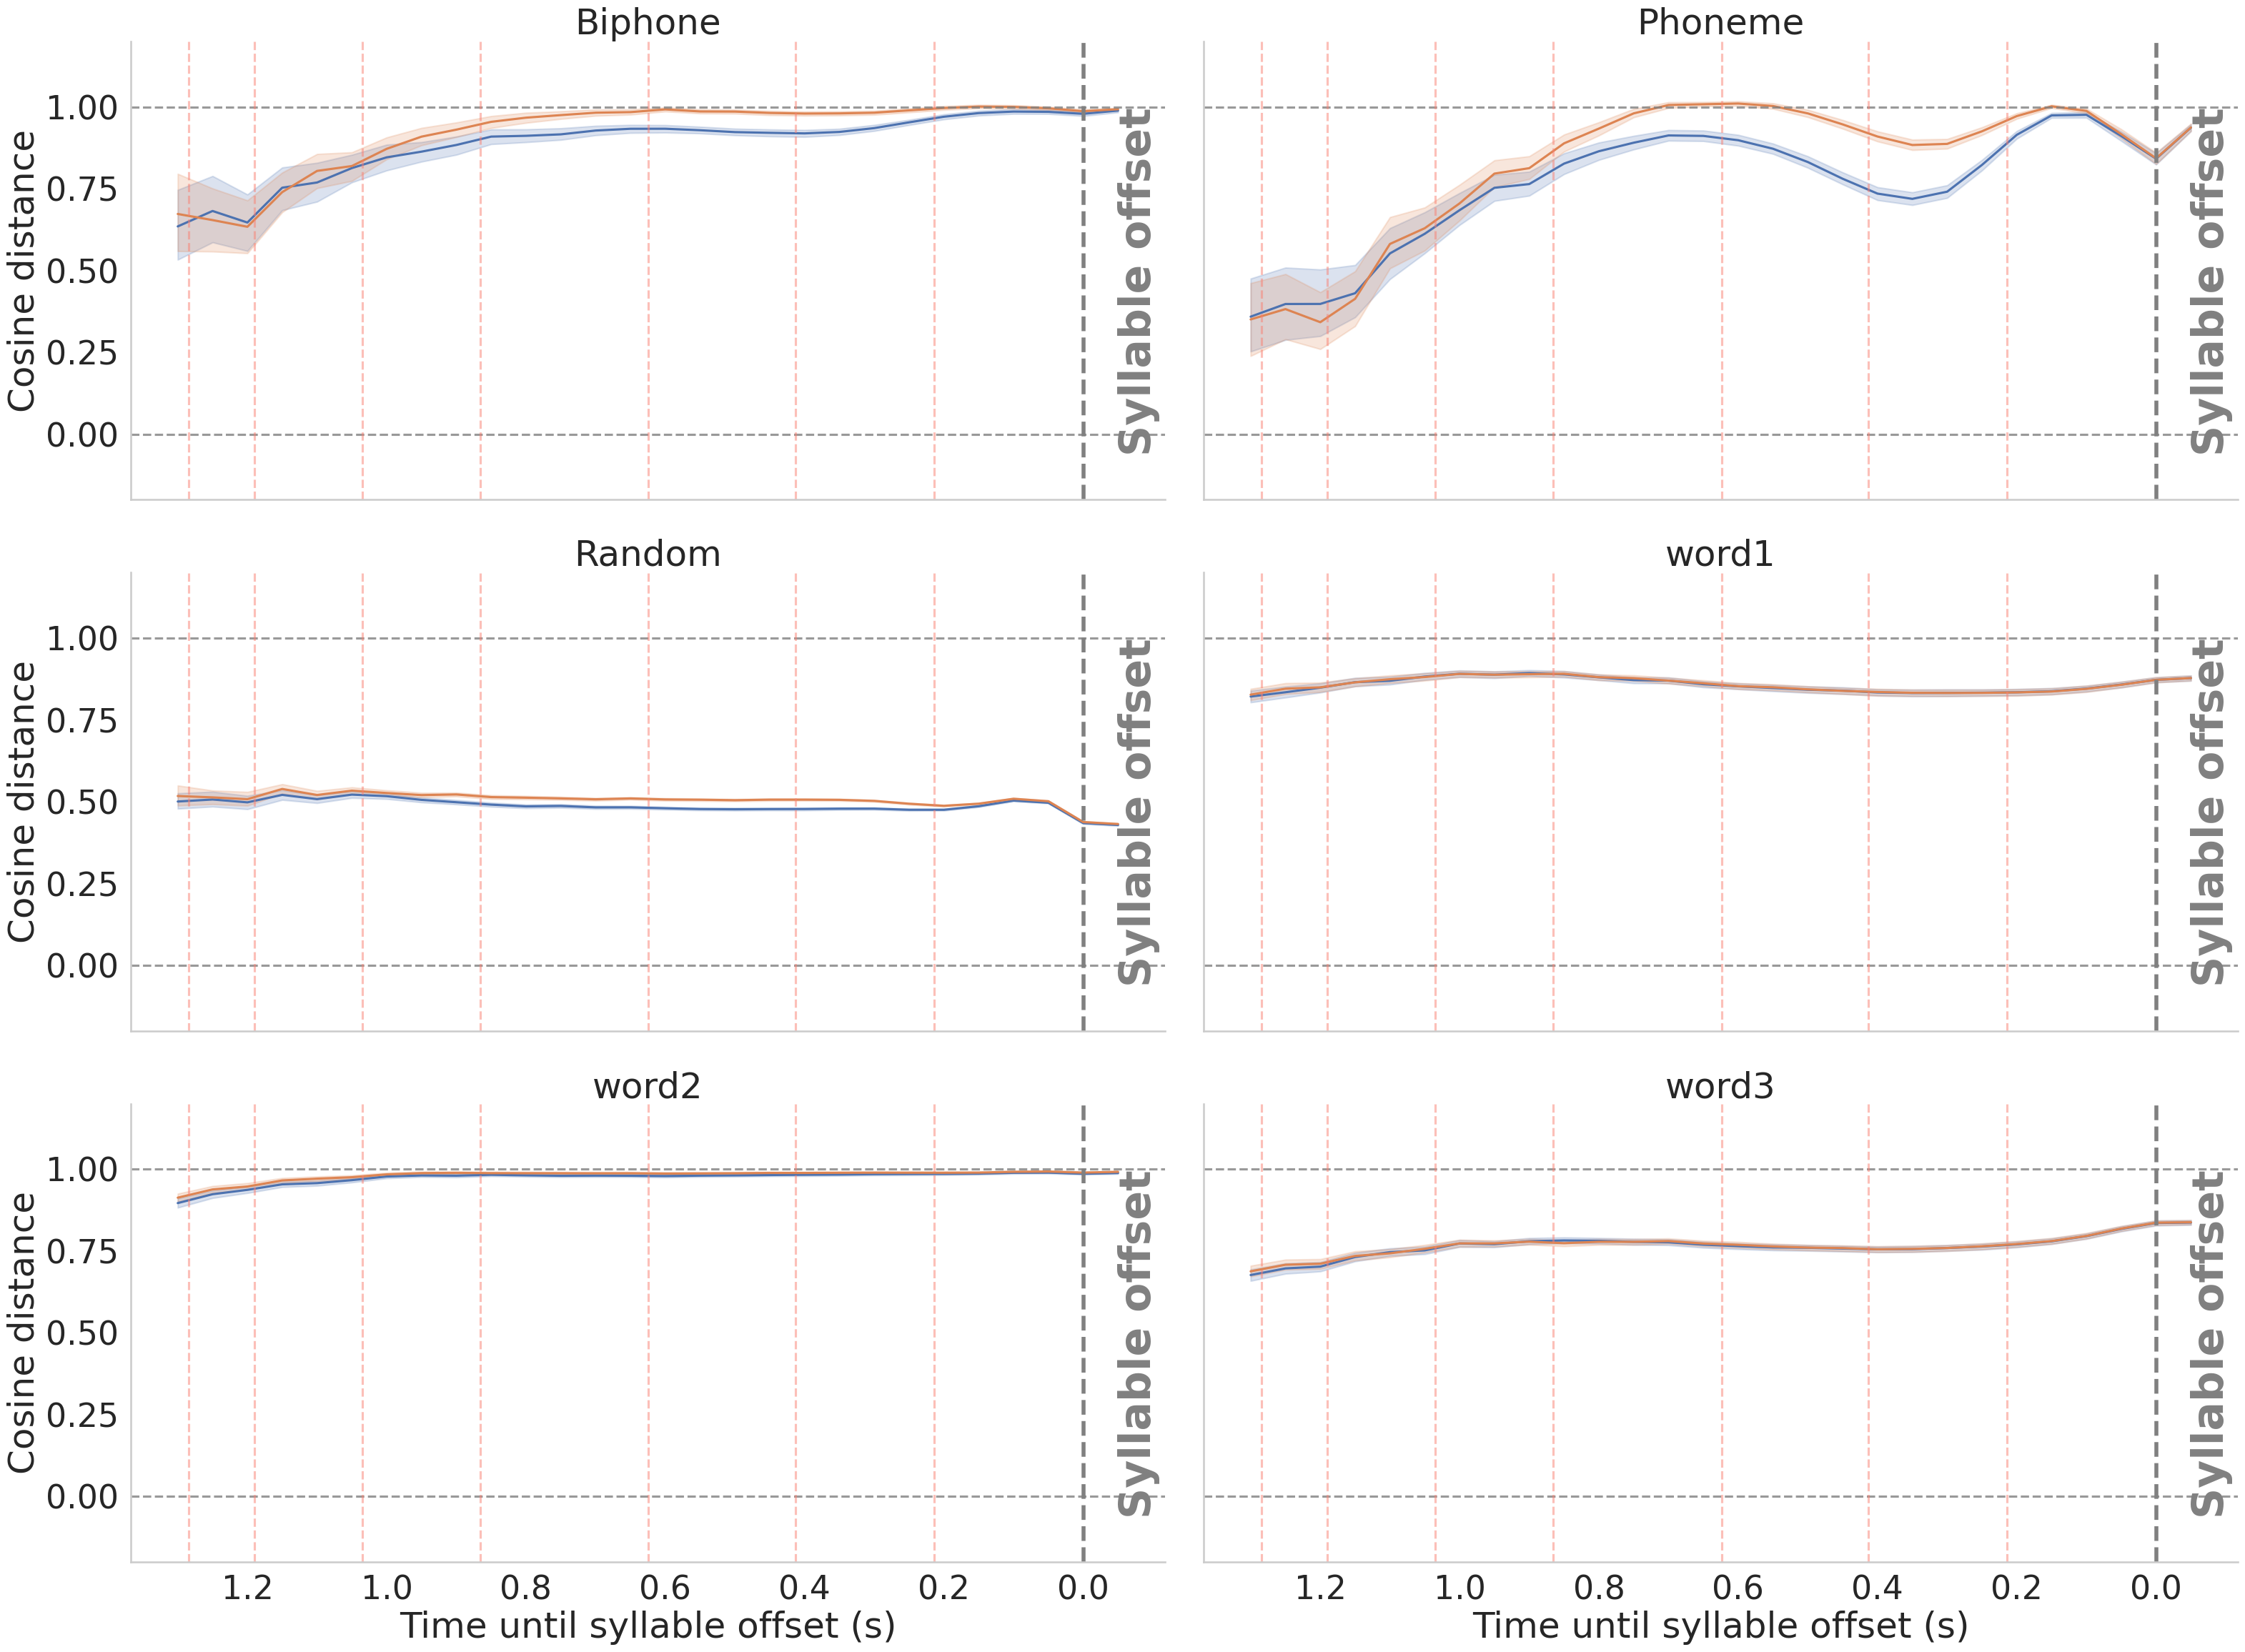

In [79]:
plot_coherence(syll_nucleus_distance_align_offset_df, "syllable", alignment="offset", col="name",
               plot_phonemes=phoneme_in_syllable_reverse_mean_onsets)

### Onset vs. nucleus

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

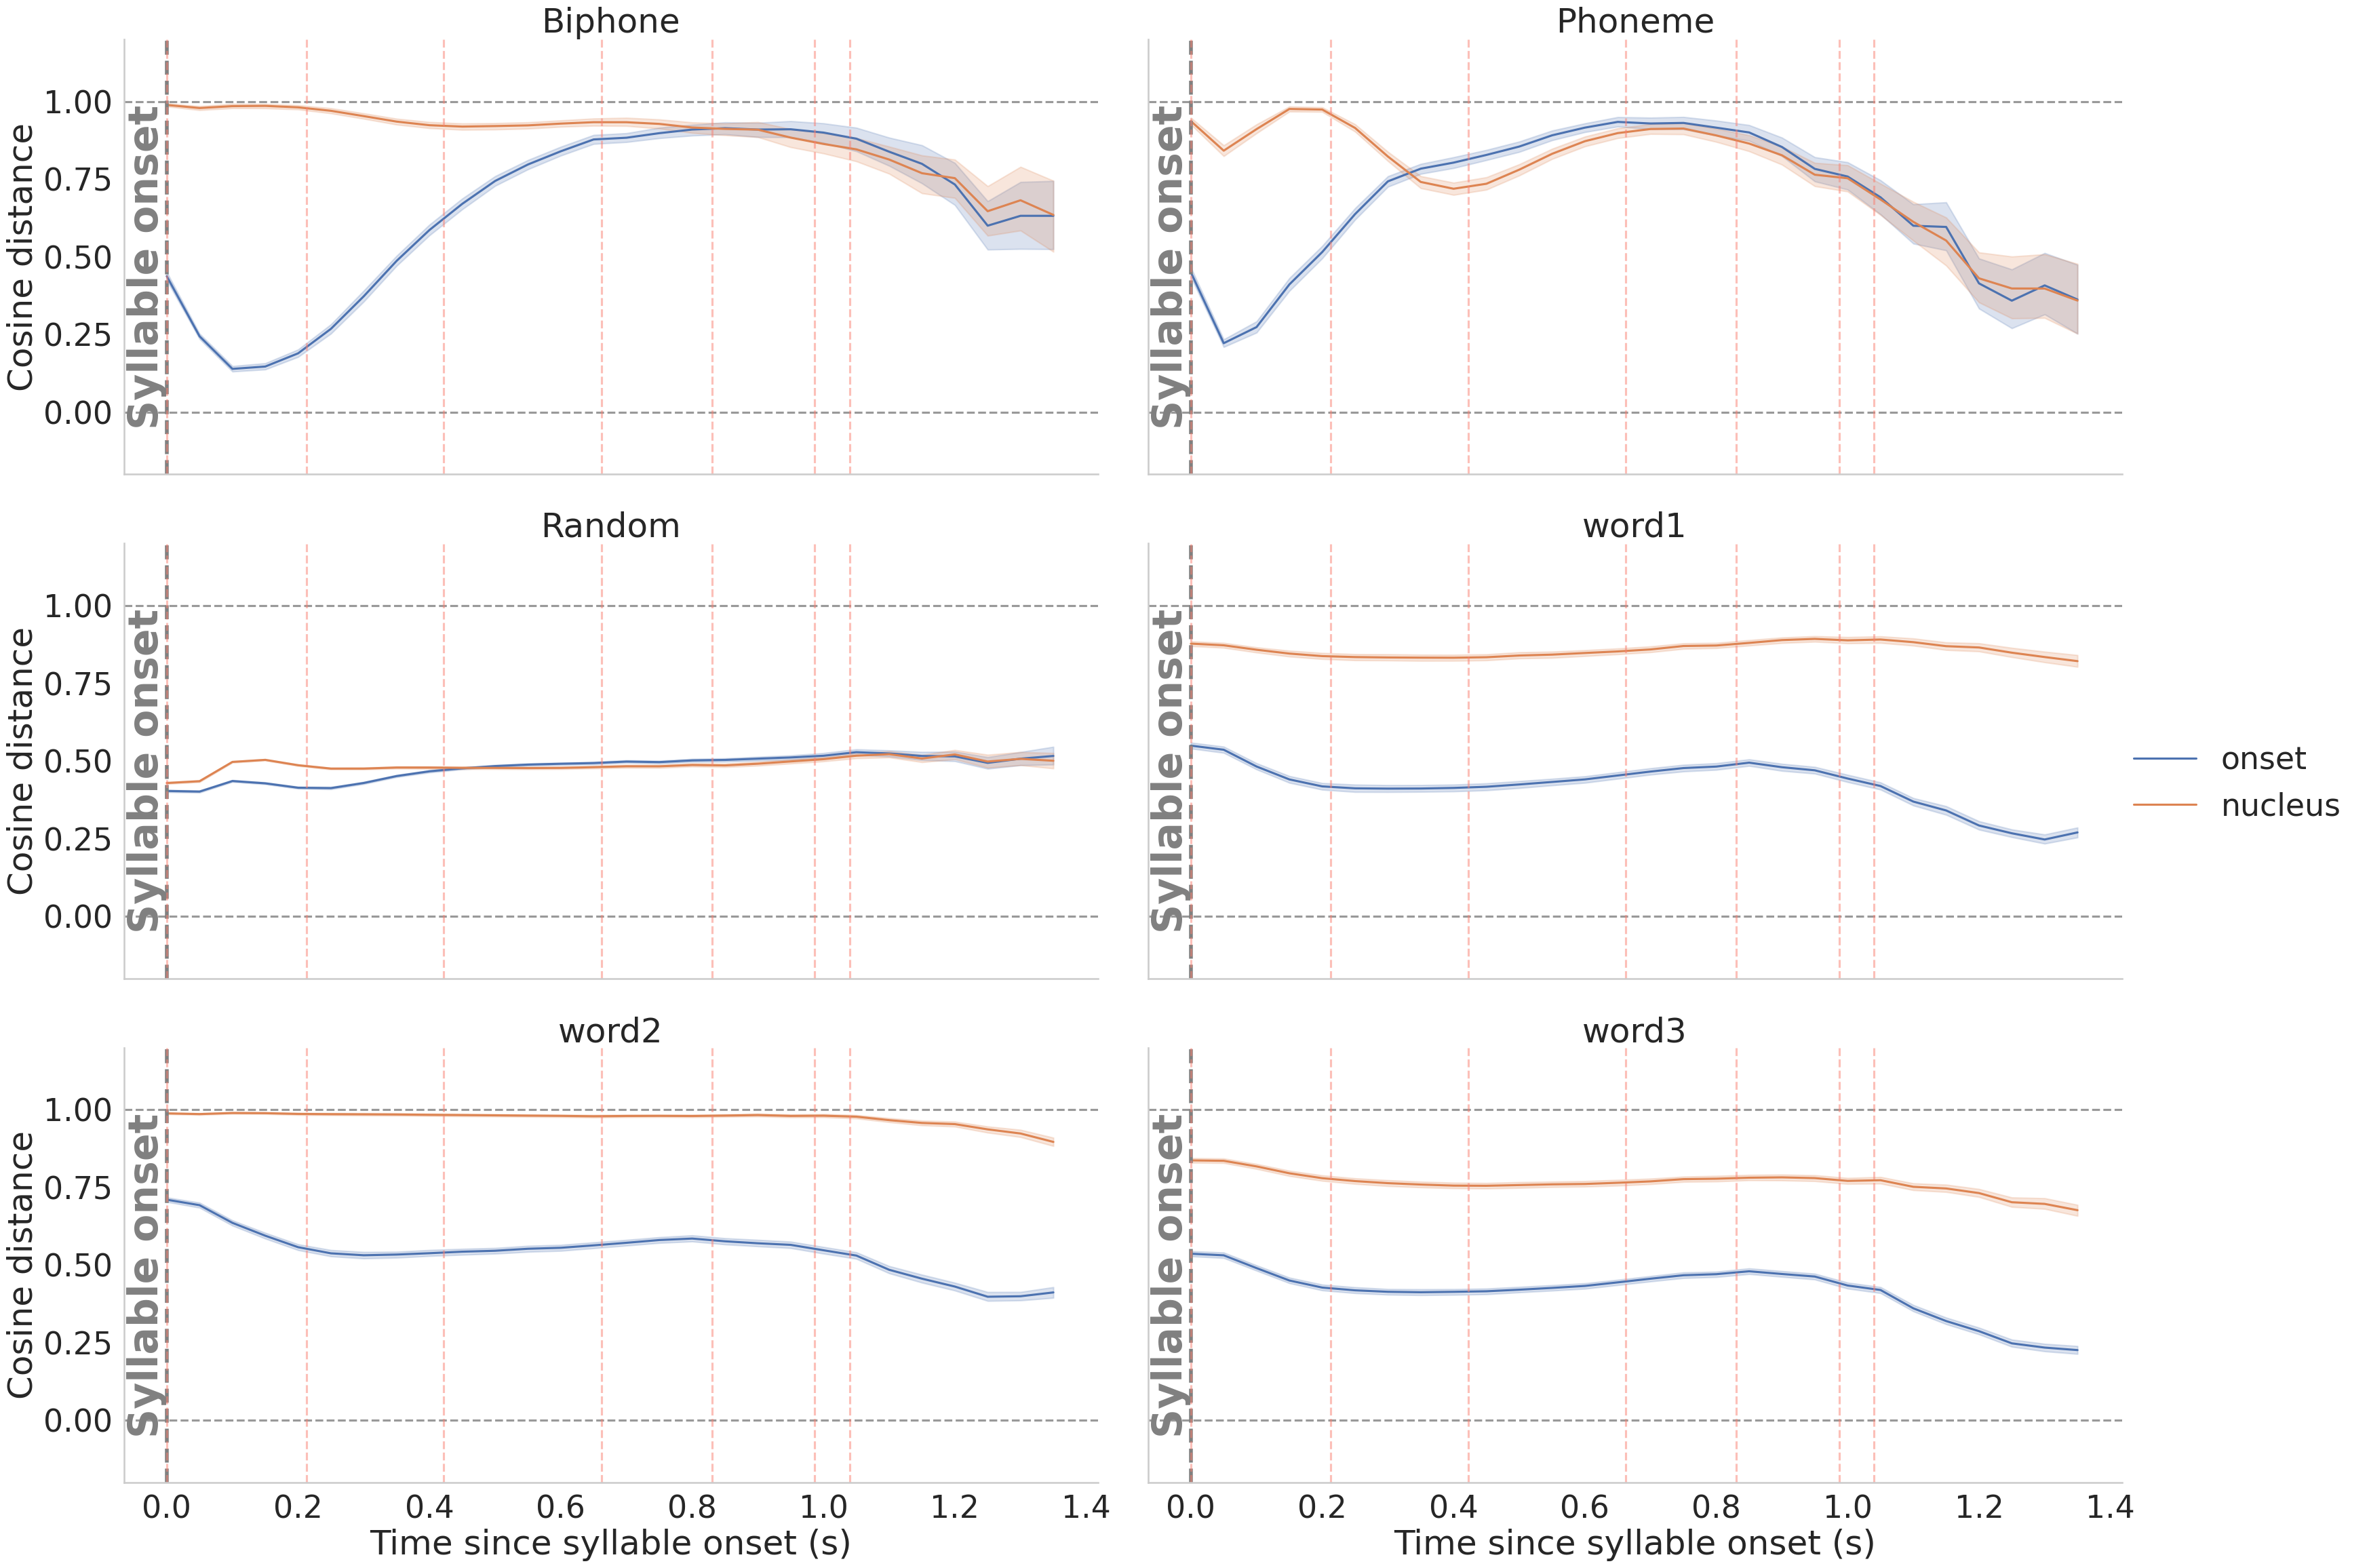

In [80]:
syll_merged_df = pd.concat([syll_onset_distance_df, syll_nucleus_distance_df], keys=["onset", "nucleus"], names=["match_type"])
syll_merged_df = syll_merged_df[syll_merged_df.type == "matched"].drop(columns="type").reset_index(level="match_type").rename(columns={"match_type": "type"})
plot_coherence(syll_merged_df.reset_index(), "syllable", col="name", hue_order=["abc", "def", "onset", "nucleus"],
               plot_phonemes=phoneme_in_syllable_mean_onsets, legend=True)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

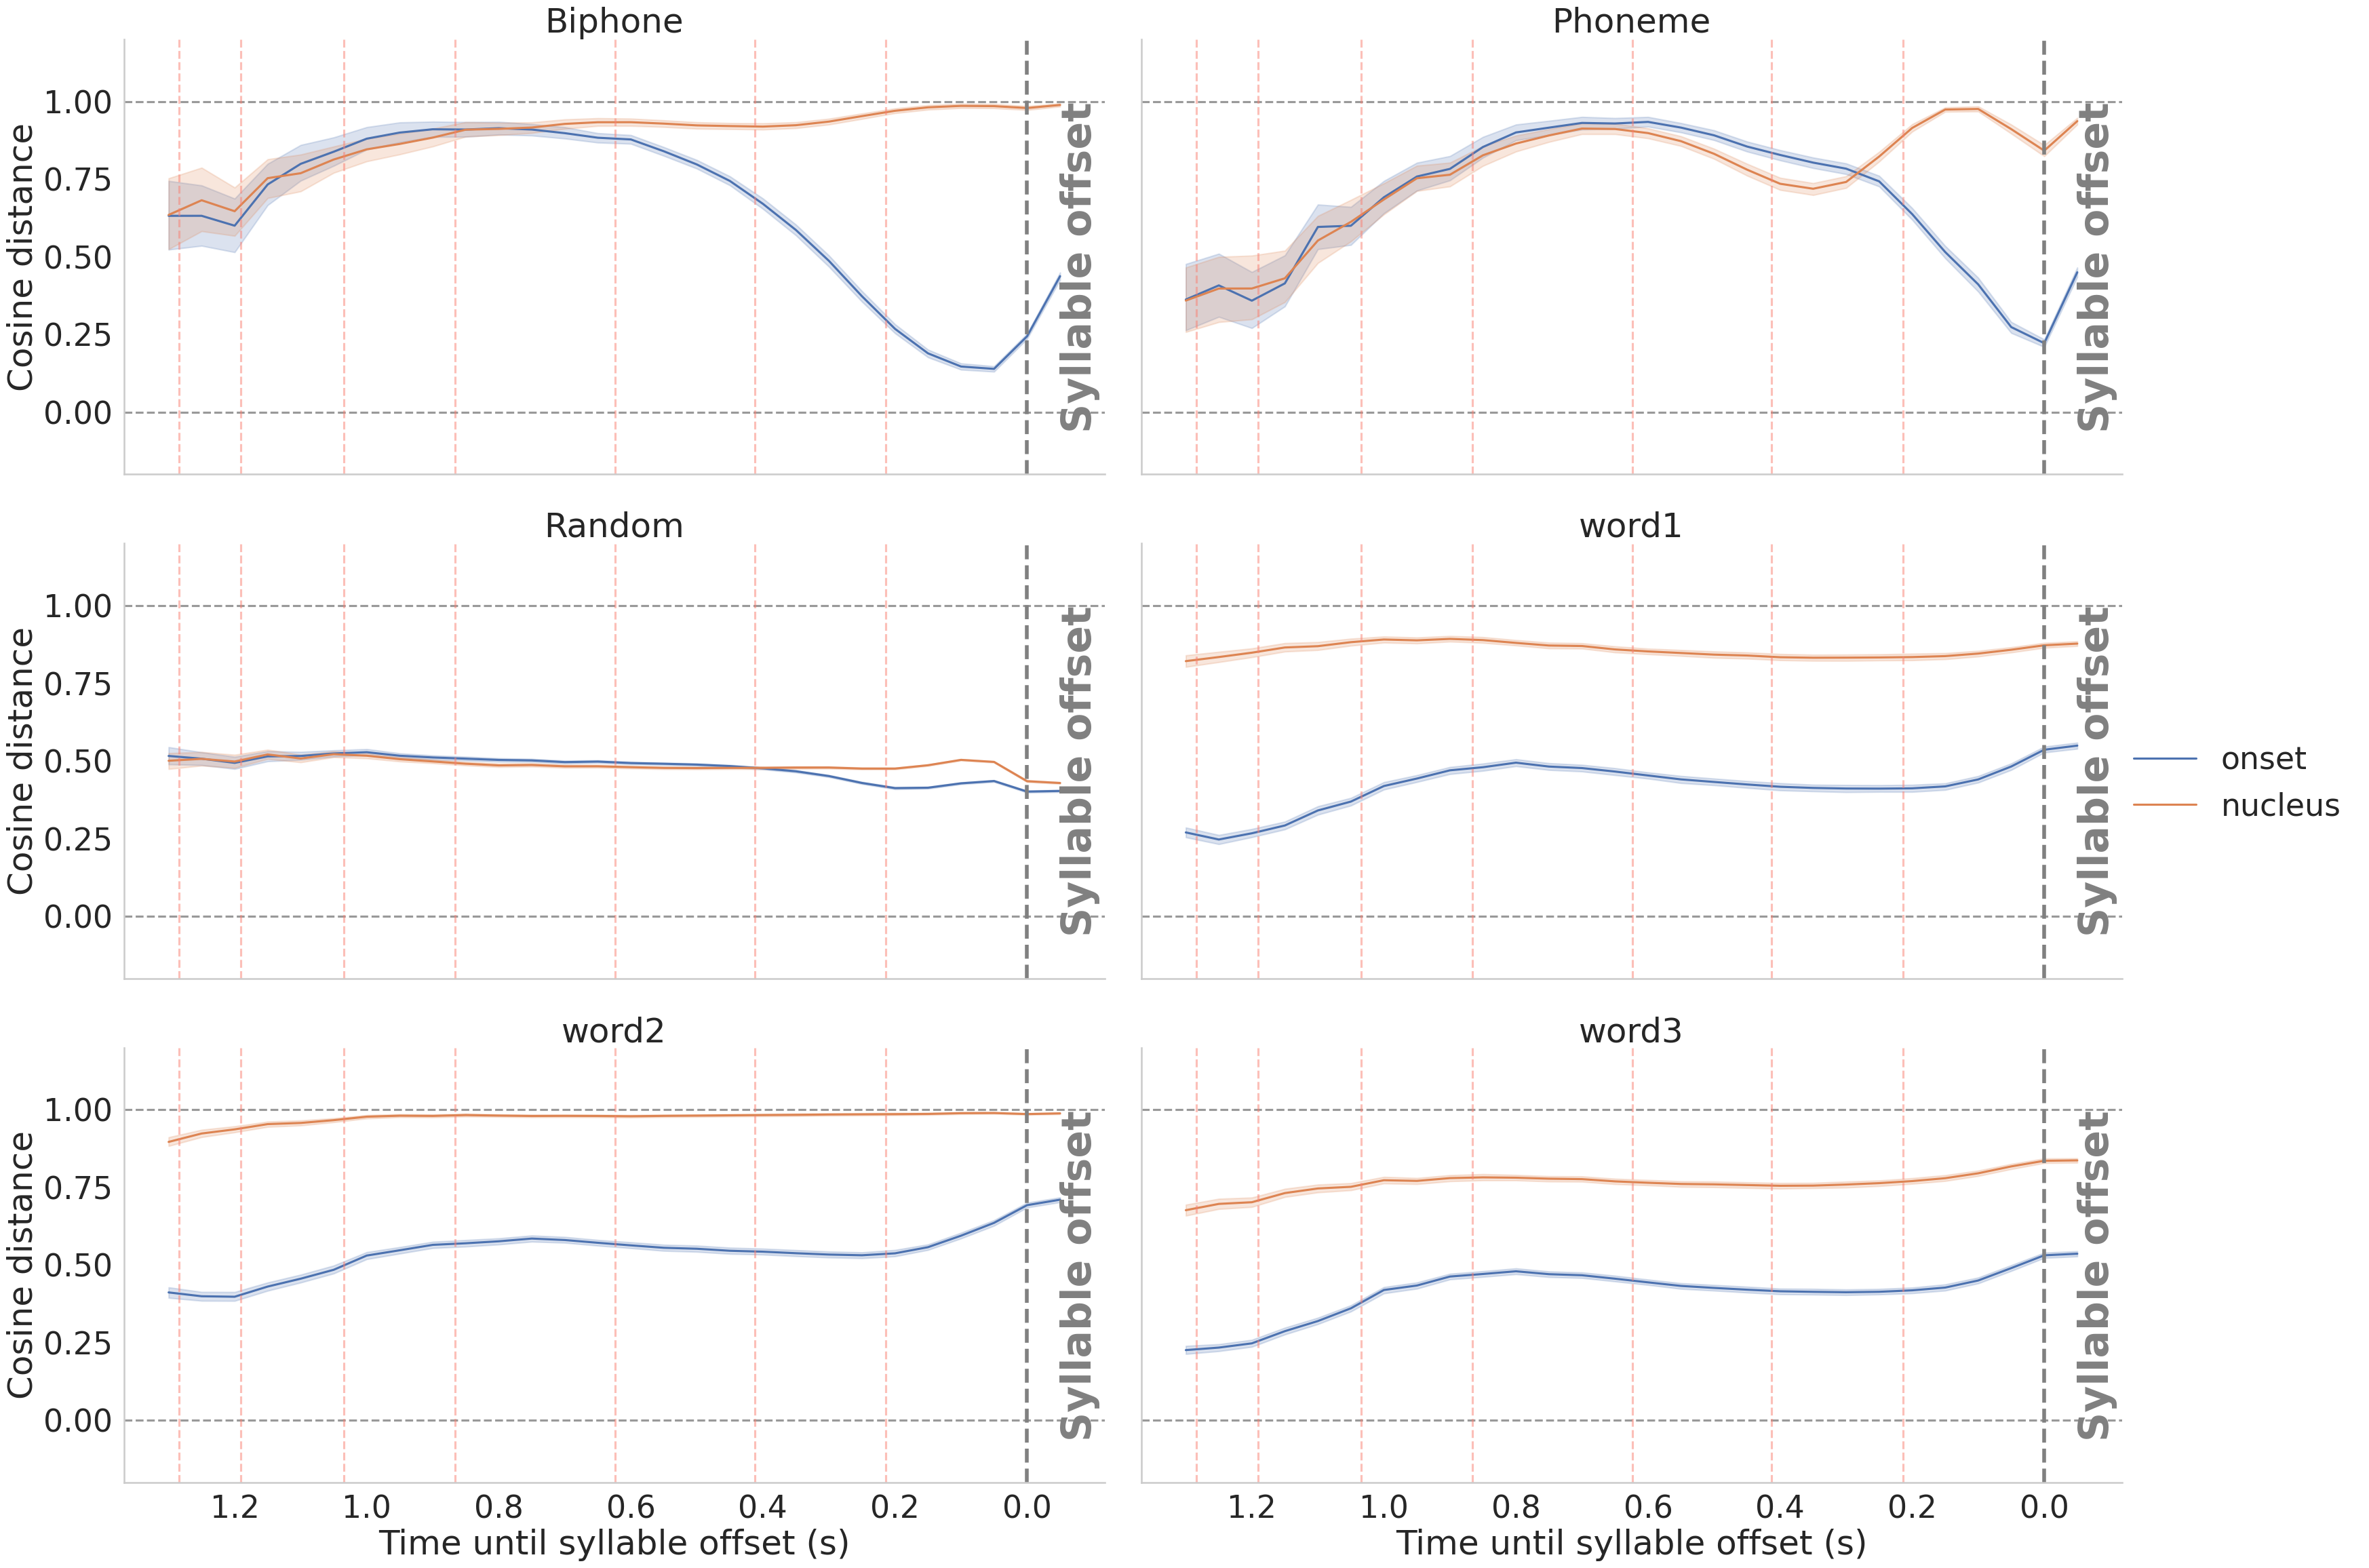

In [81]:
syll_merged_offset_df = pd.concat([syll_onset_distance_align_offset_df, syll_nucleus_distance_align_offset_df], 
                                  keys=["onset", "nucleus"], names=["match_type"])
syll_merged_offset_df = syll_merged_offset_df[syll_merged_offset_df.type == "matched"].drop(columns="type").reset_index(level="match_type").rename(columns={"match_type": "type"})
plot_coherence(syll_merged_offset_df.reset_index(), "syllable", alignment="offset",
               col="name", hue_order=["abc", "def", "onset", "nucleus"],
               plot_phonemes=phoneme_in_syllable_reverse_mean_onsets, legend=True)

## Word coherence

In [82]:
word_distance_df = load_grouped_distances("**/lexical_coherence/distances.csv")
word_distance_align_offset_df = load_grouped_distances("**/lexical_coherence/distances_aligned_offset.csv")

/tmp/ipykernel_2321267/2152939426.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \
/tmp/ipykernel_2321267/2152939426.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \


In [83]:
# DEV
word_distance_df["time"] = word_distance_df["frame"] / 20
word_distance_align_offset_df["time"] = word_distance_align_offset_df["frame"] / 20

In [84]:
sorted(word_distance_df.word.unique())[50:]

['accuse',
 'accused',
 'accustomed',
 'achieved',
 'achievement',
 'acknowledge',
 'acknowledged',
 'acquaintance',
 'acquaintances',
 'acquainted',
 'acquired',
 'acres',
 'across',
 'act',
 'acted',
 'acting',
 'action',
 'actions',
 'active',
 'activities',
 'activity',
 'actors',
 'acts',
 'actual',
 'actually',
 'acute',
 'adam',
 "adam's",
 'adams',
 'adapted',
 'add',
 'added',
 'adder',
 'adders',
 'adding',
 'addition',
 'additional',
 'address',
 'addressed',
 'addressing',
 'adela',
 'adjoining',
 'adjusted',
 'adjustment',
 'administration',
 'admirable',
 'admiral',
 'admiralty',
 'admiration',
 'admire',
 'admired',
 'admiring',
 'admission',
 'admit',
 'admitted',
 'adopted',
 'advance',
 'advanced',
 'advances',
 'advancing',
 'advantage',
 'advantageous',
 'advantages',
 'adventure',
 'adventures',
 'adversary',
 'advertisement',
 'advertising',
 'advice',
 'advise',
 'advised',
 'affair',
 'affairs',
 'affect',
 'affected',
 'affecting',
 'affection',
 'affectionate'

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


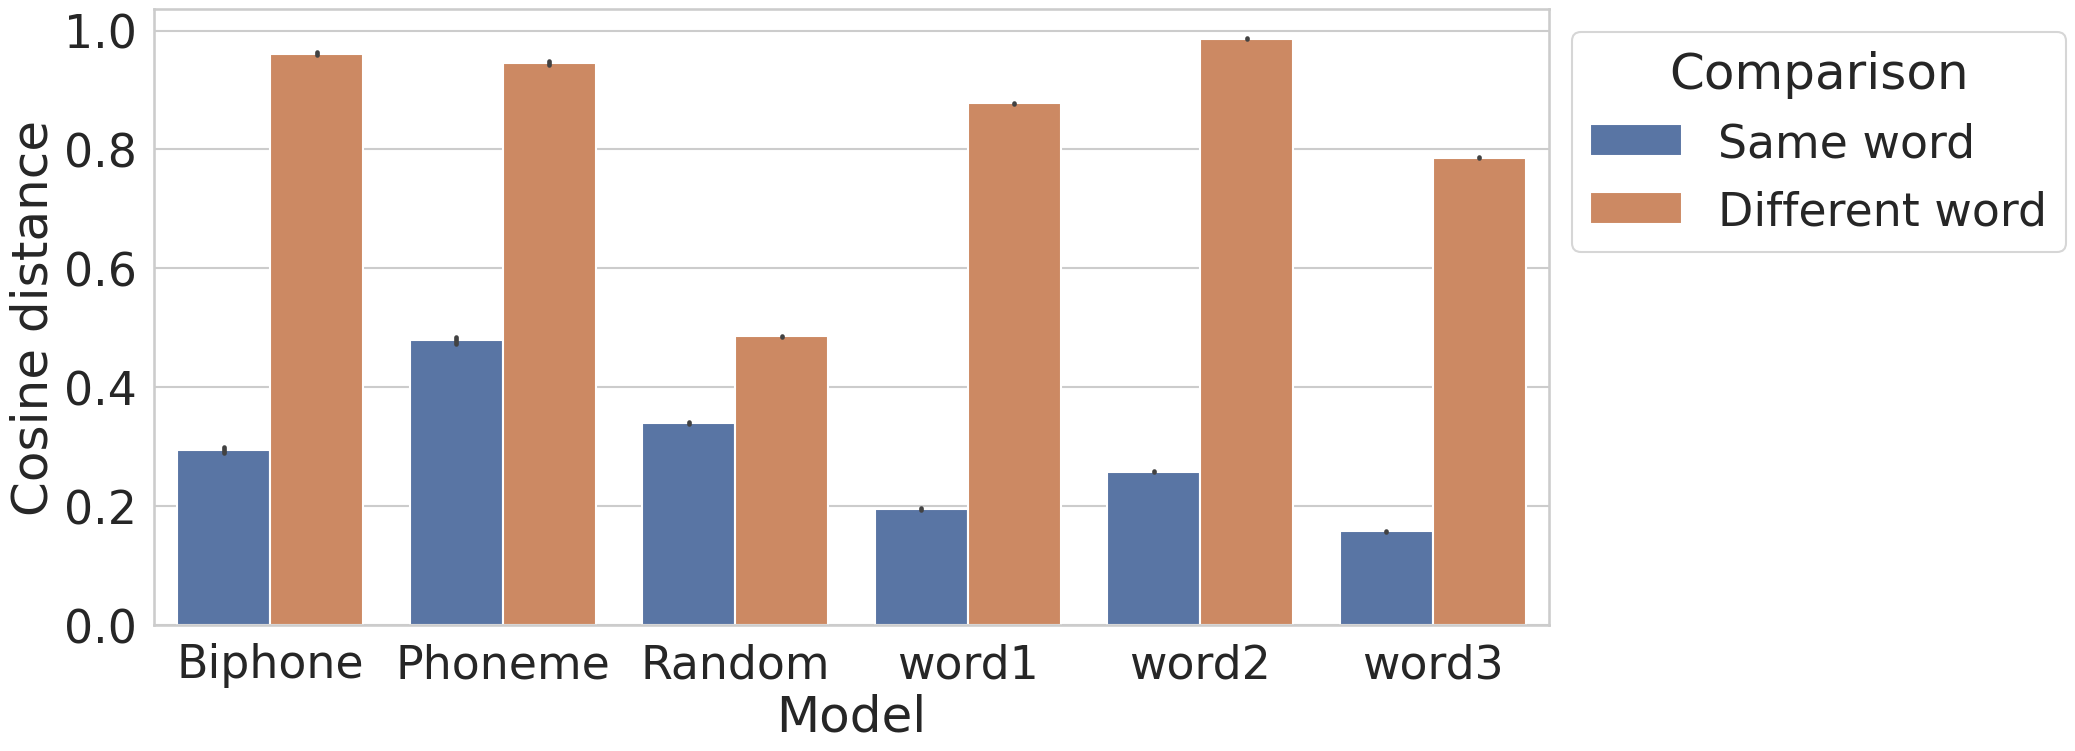

In [85]:
f, ax = plt.subplots(figsize=(18, 8))
word_plot_data = word_distance_df.reset_index()
word_plot_data["type"] = word_plot_data["type"].map(
    {"within": "Same word",
     "between": "Different word"}
)
sns.barplot(data=word_plot_data,
            x="name", y="distance", hue="type", ax=ax)

ax.set_ylabel("Cosine distance")
ax.set_xlabel("Model")
ax.legend(title="Comparison", loc="upper left", bbox_to_anchor=(1, 1))

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

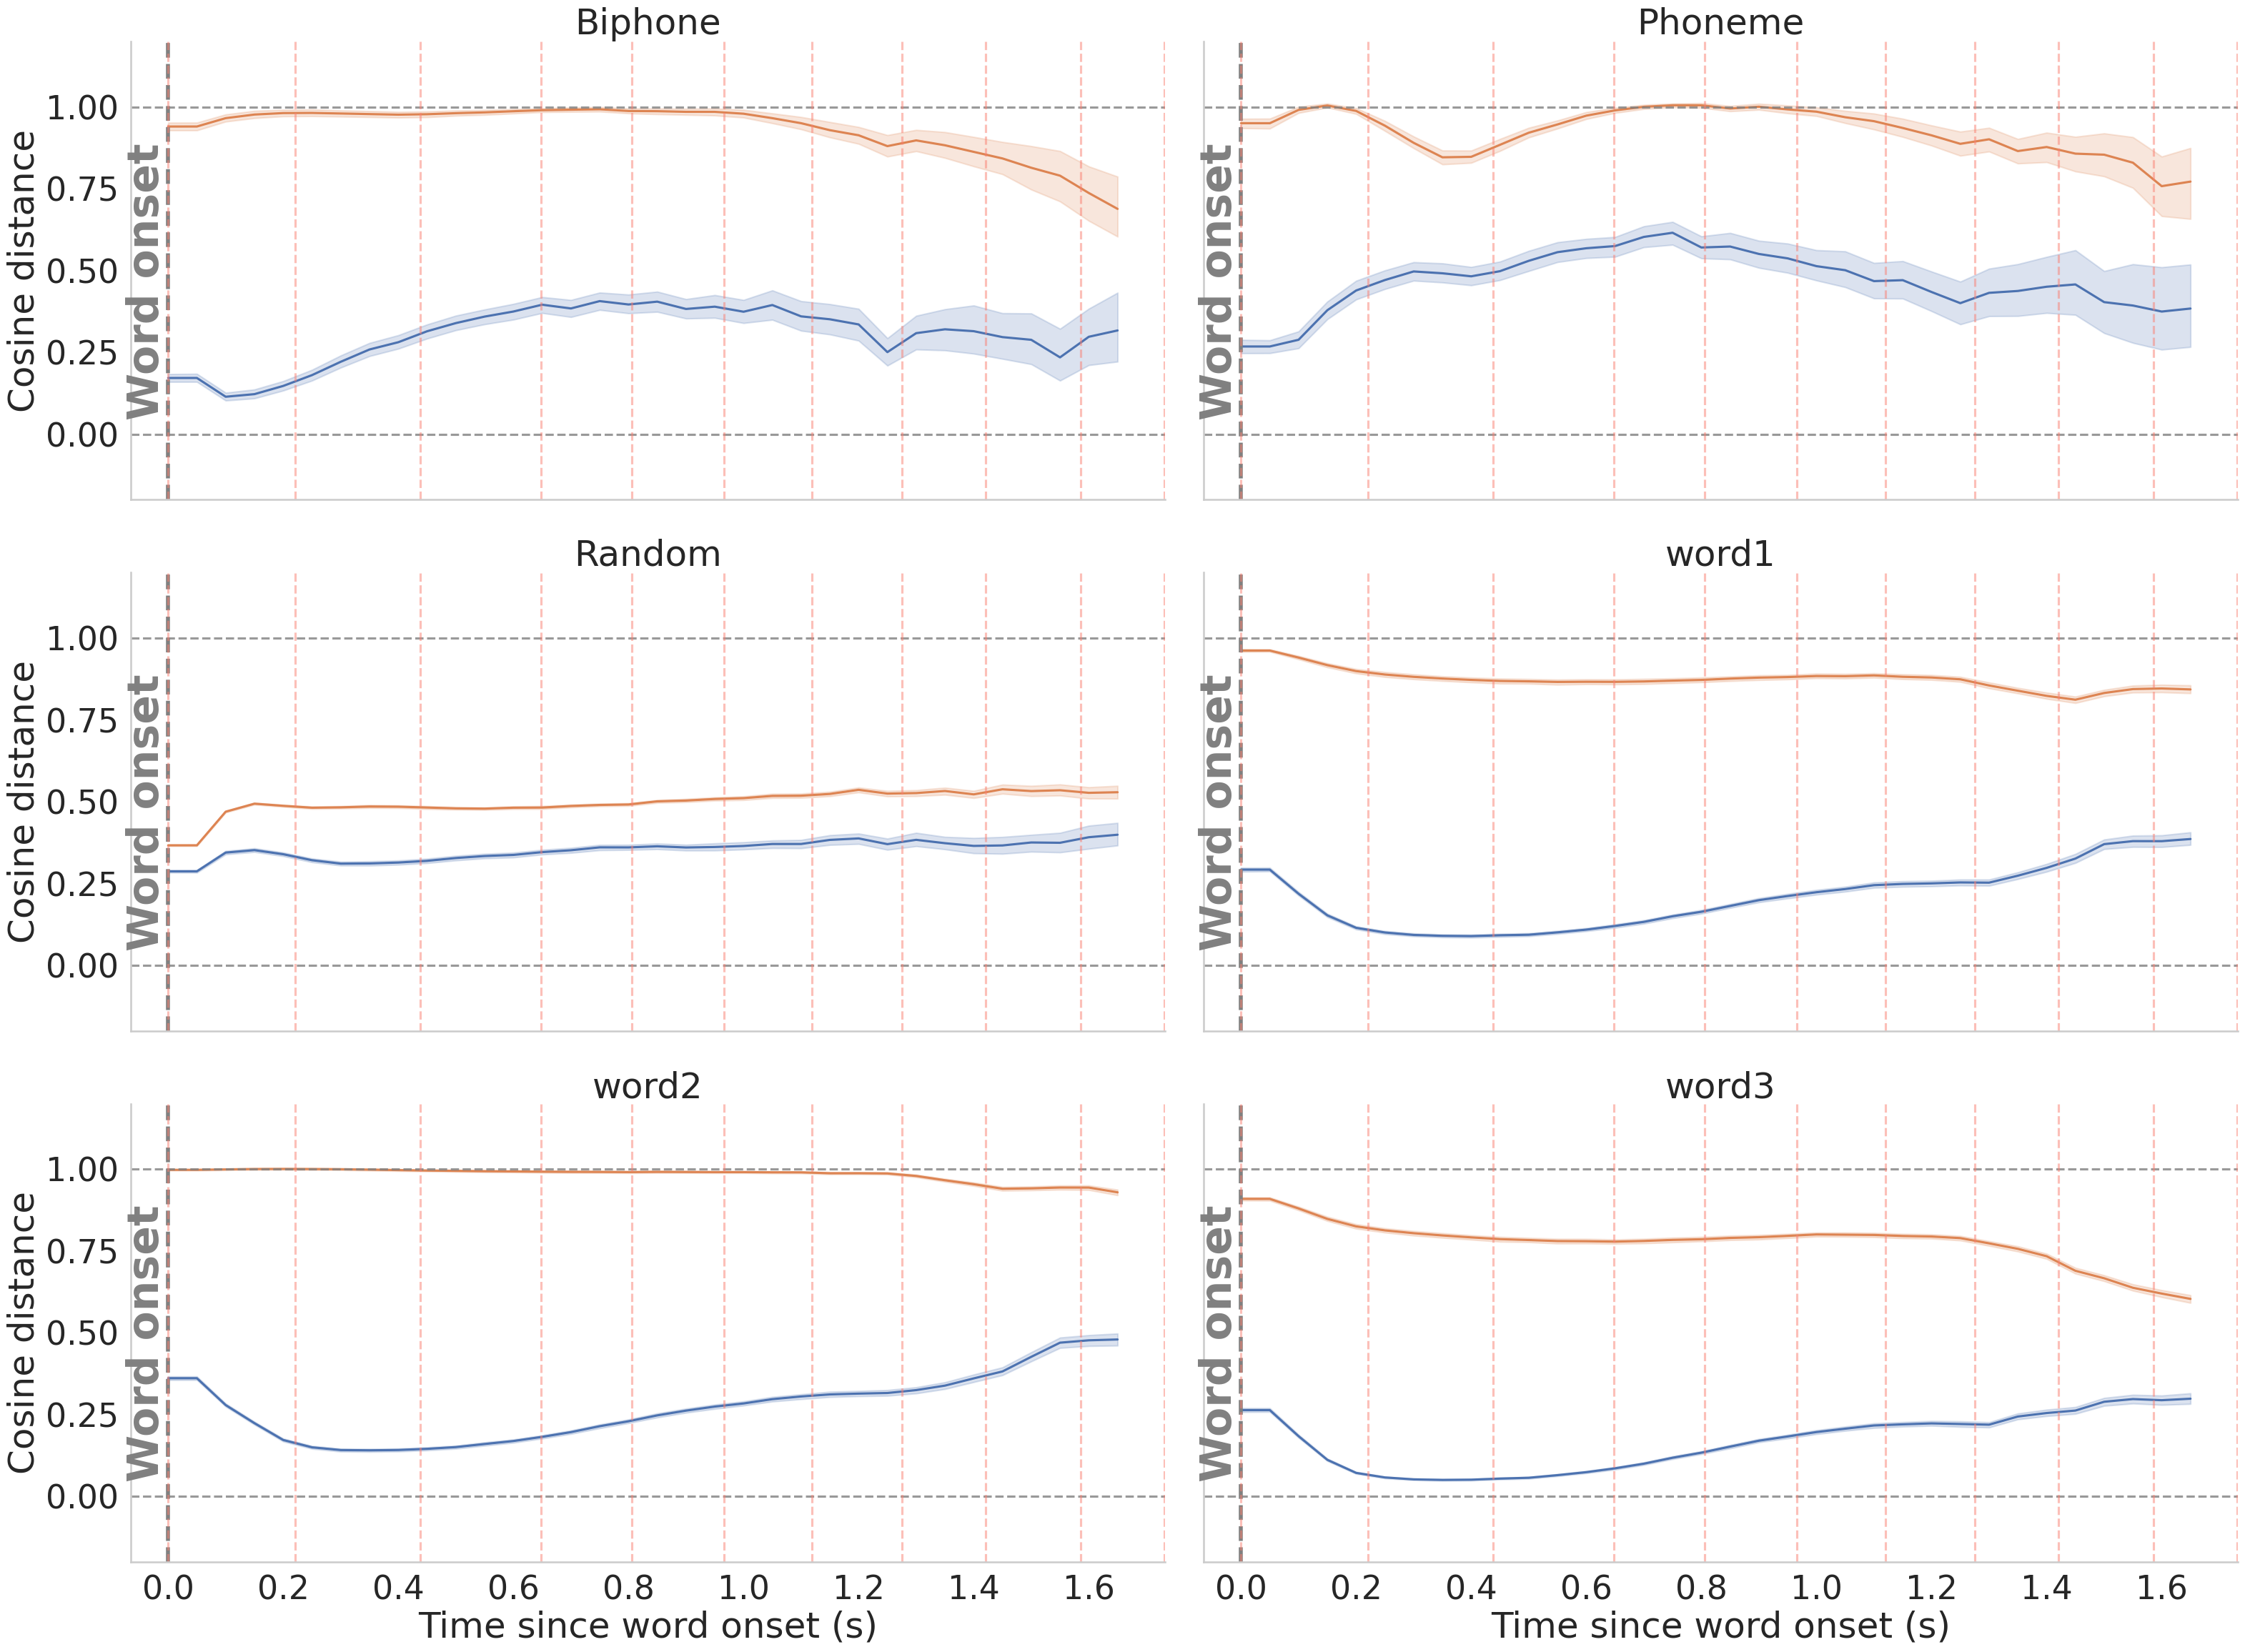

In [86]:
plot_coherence(word_distance_df, "word", col="name", plot_phonemes=phoneme_in_word_mean_onsets)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

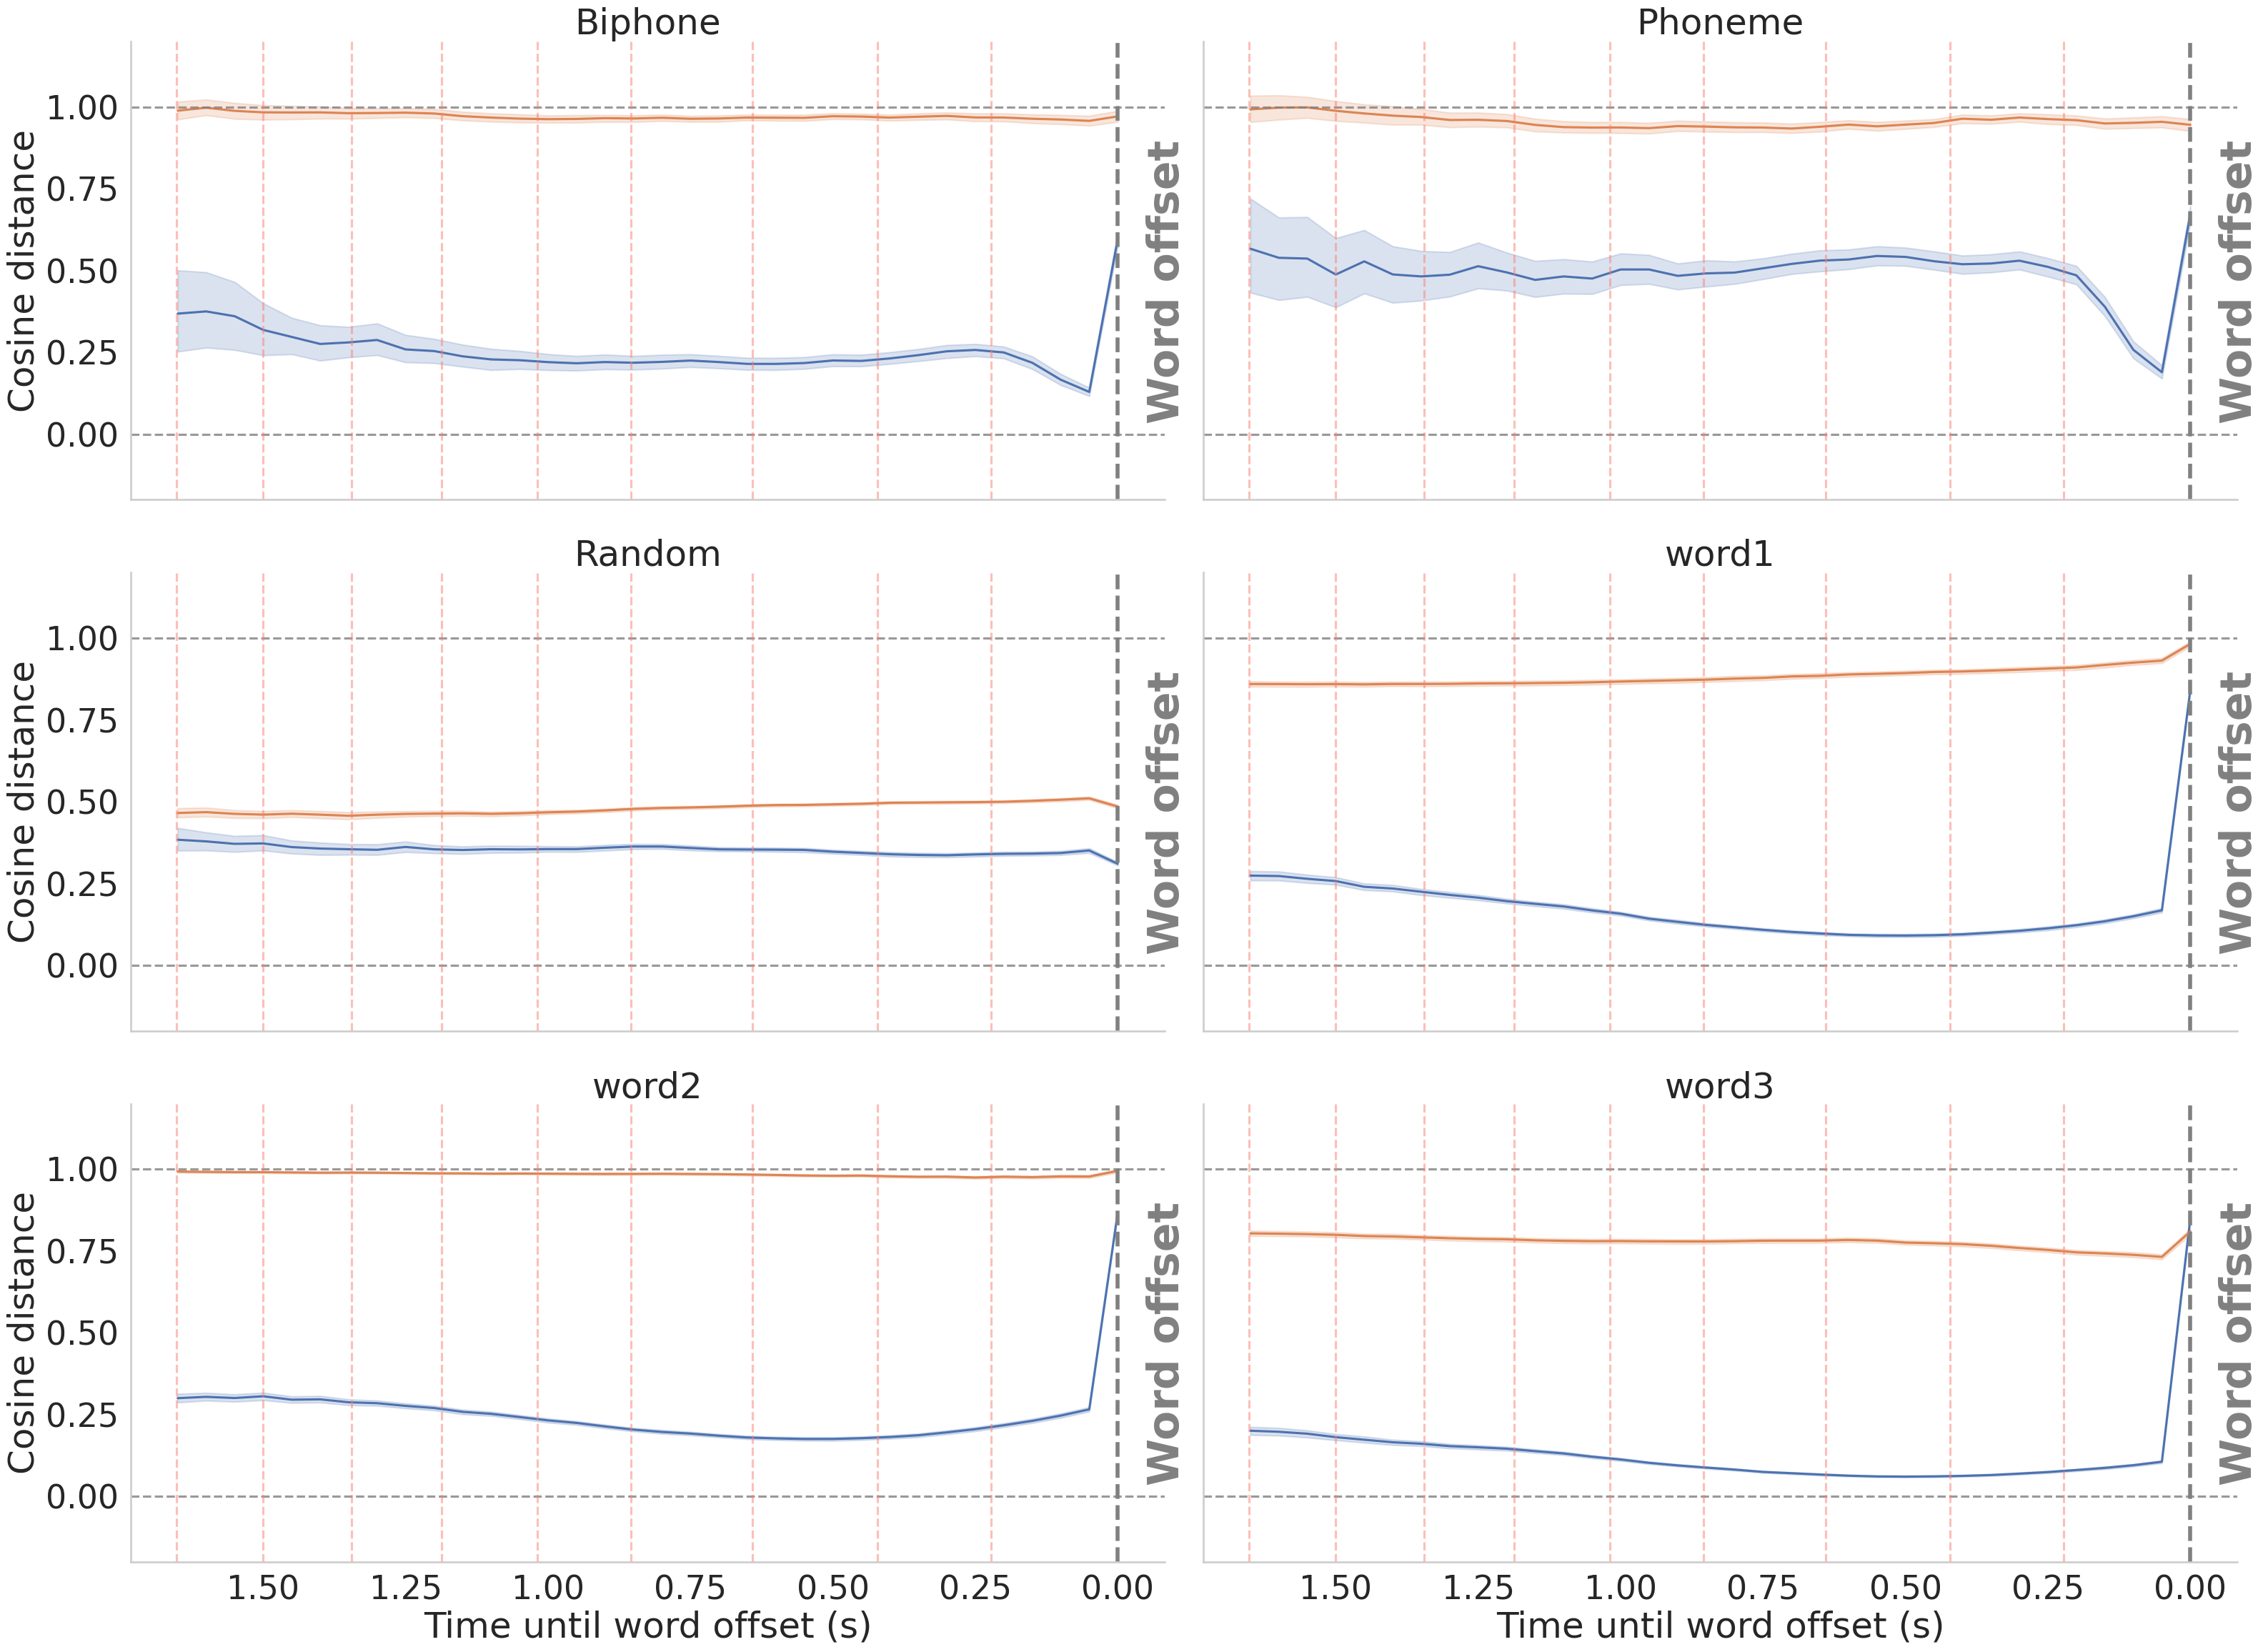

In [87]:
plot_coherence(word_distance_align_offset_df, "word", alignment="offset", col="name",
               plot_phonemes=phoneme_in_word_reverse_mean_onsets)

### Grouped by onset

In [88]:
word_onset_distance_df = load_grouped_distances("**/lexical_coherence/distances-grouped_onset.csv")
word_onset_distance_align_offset_df = load_grouped_distances("**/lexical_coherence/distances-grouped_onset_aligned_offset.csv")

/tmp/ipykernel_2321267/2152939426.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \
/tmp/ipykernel_2321267/2152939426.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \


In [89]:
# DEV
word_onset_distance_df["time"] = word_onset_distance_df["frame"] / 20
word_onset_distance_align_offset_df["time"] = word_onset_distance_align_offset_df["frame"] / 20

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

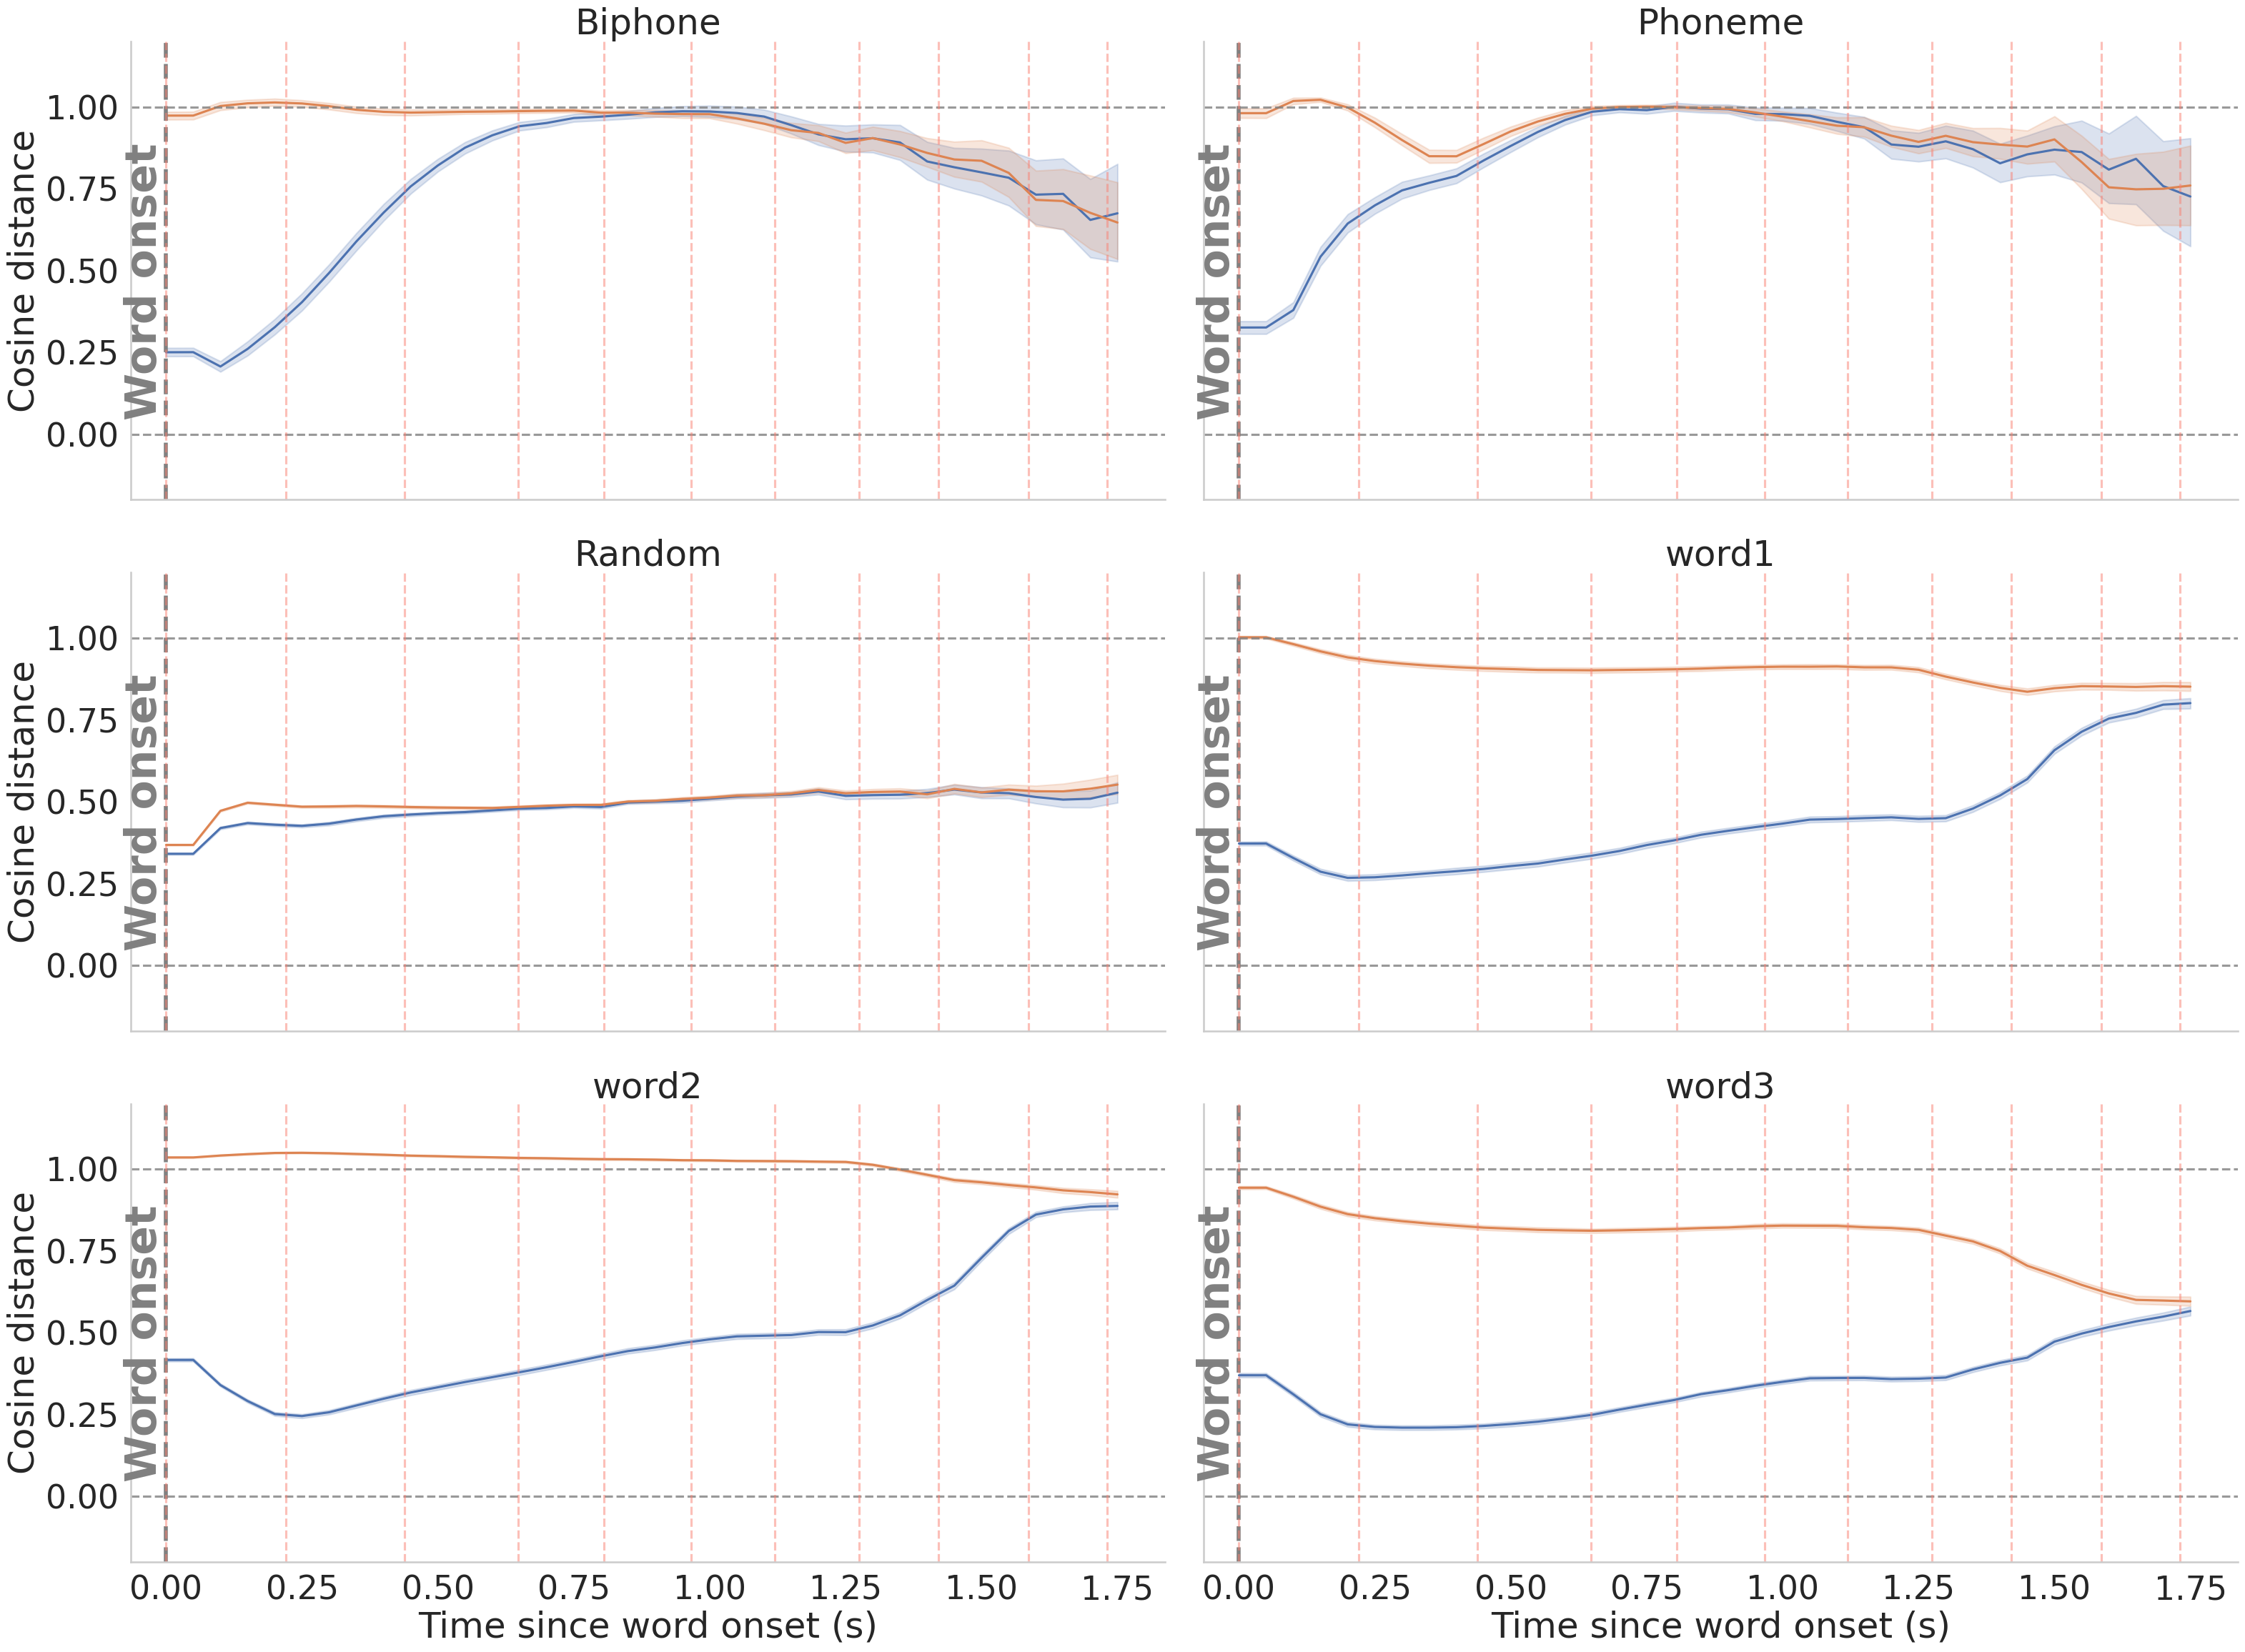

In [90]:
plot_coherence(word_onset_distance_df, "word", col="name", plot_phonemes=phoneme_in_word_mean_onsets)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

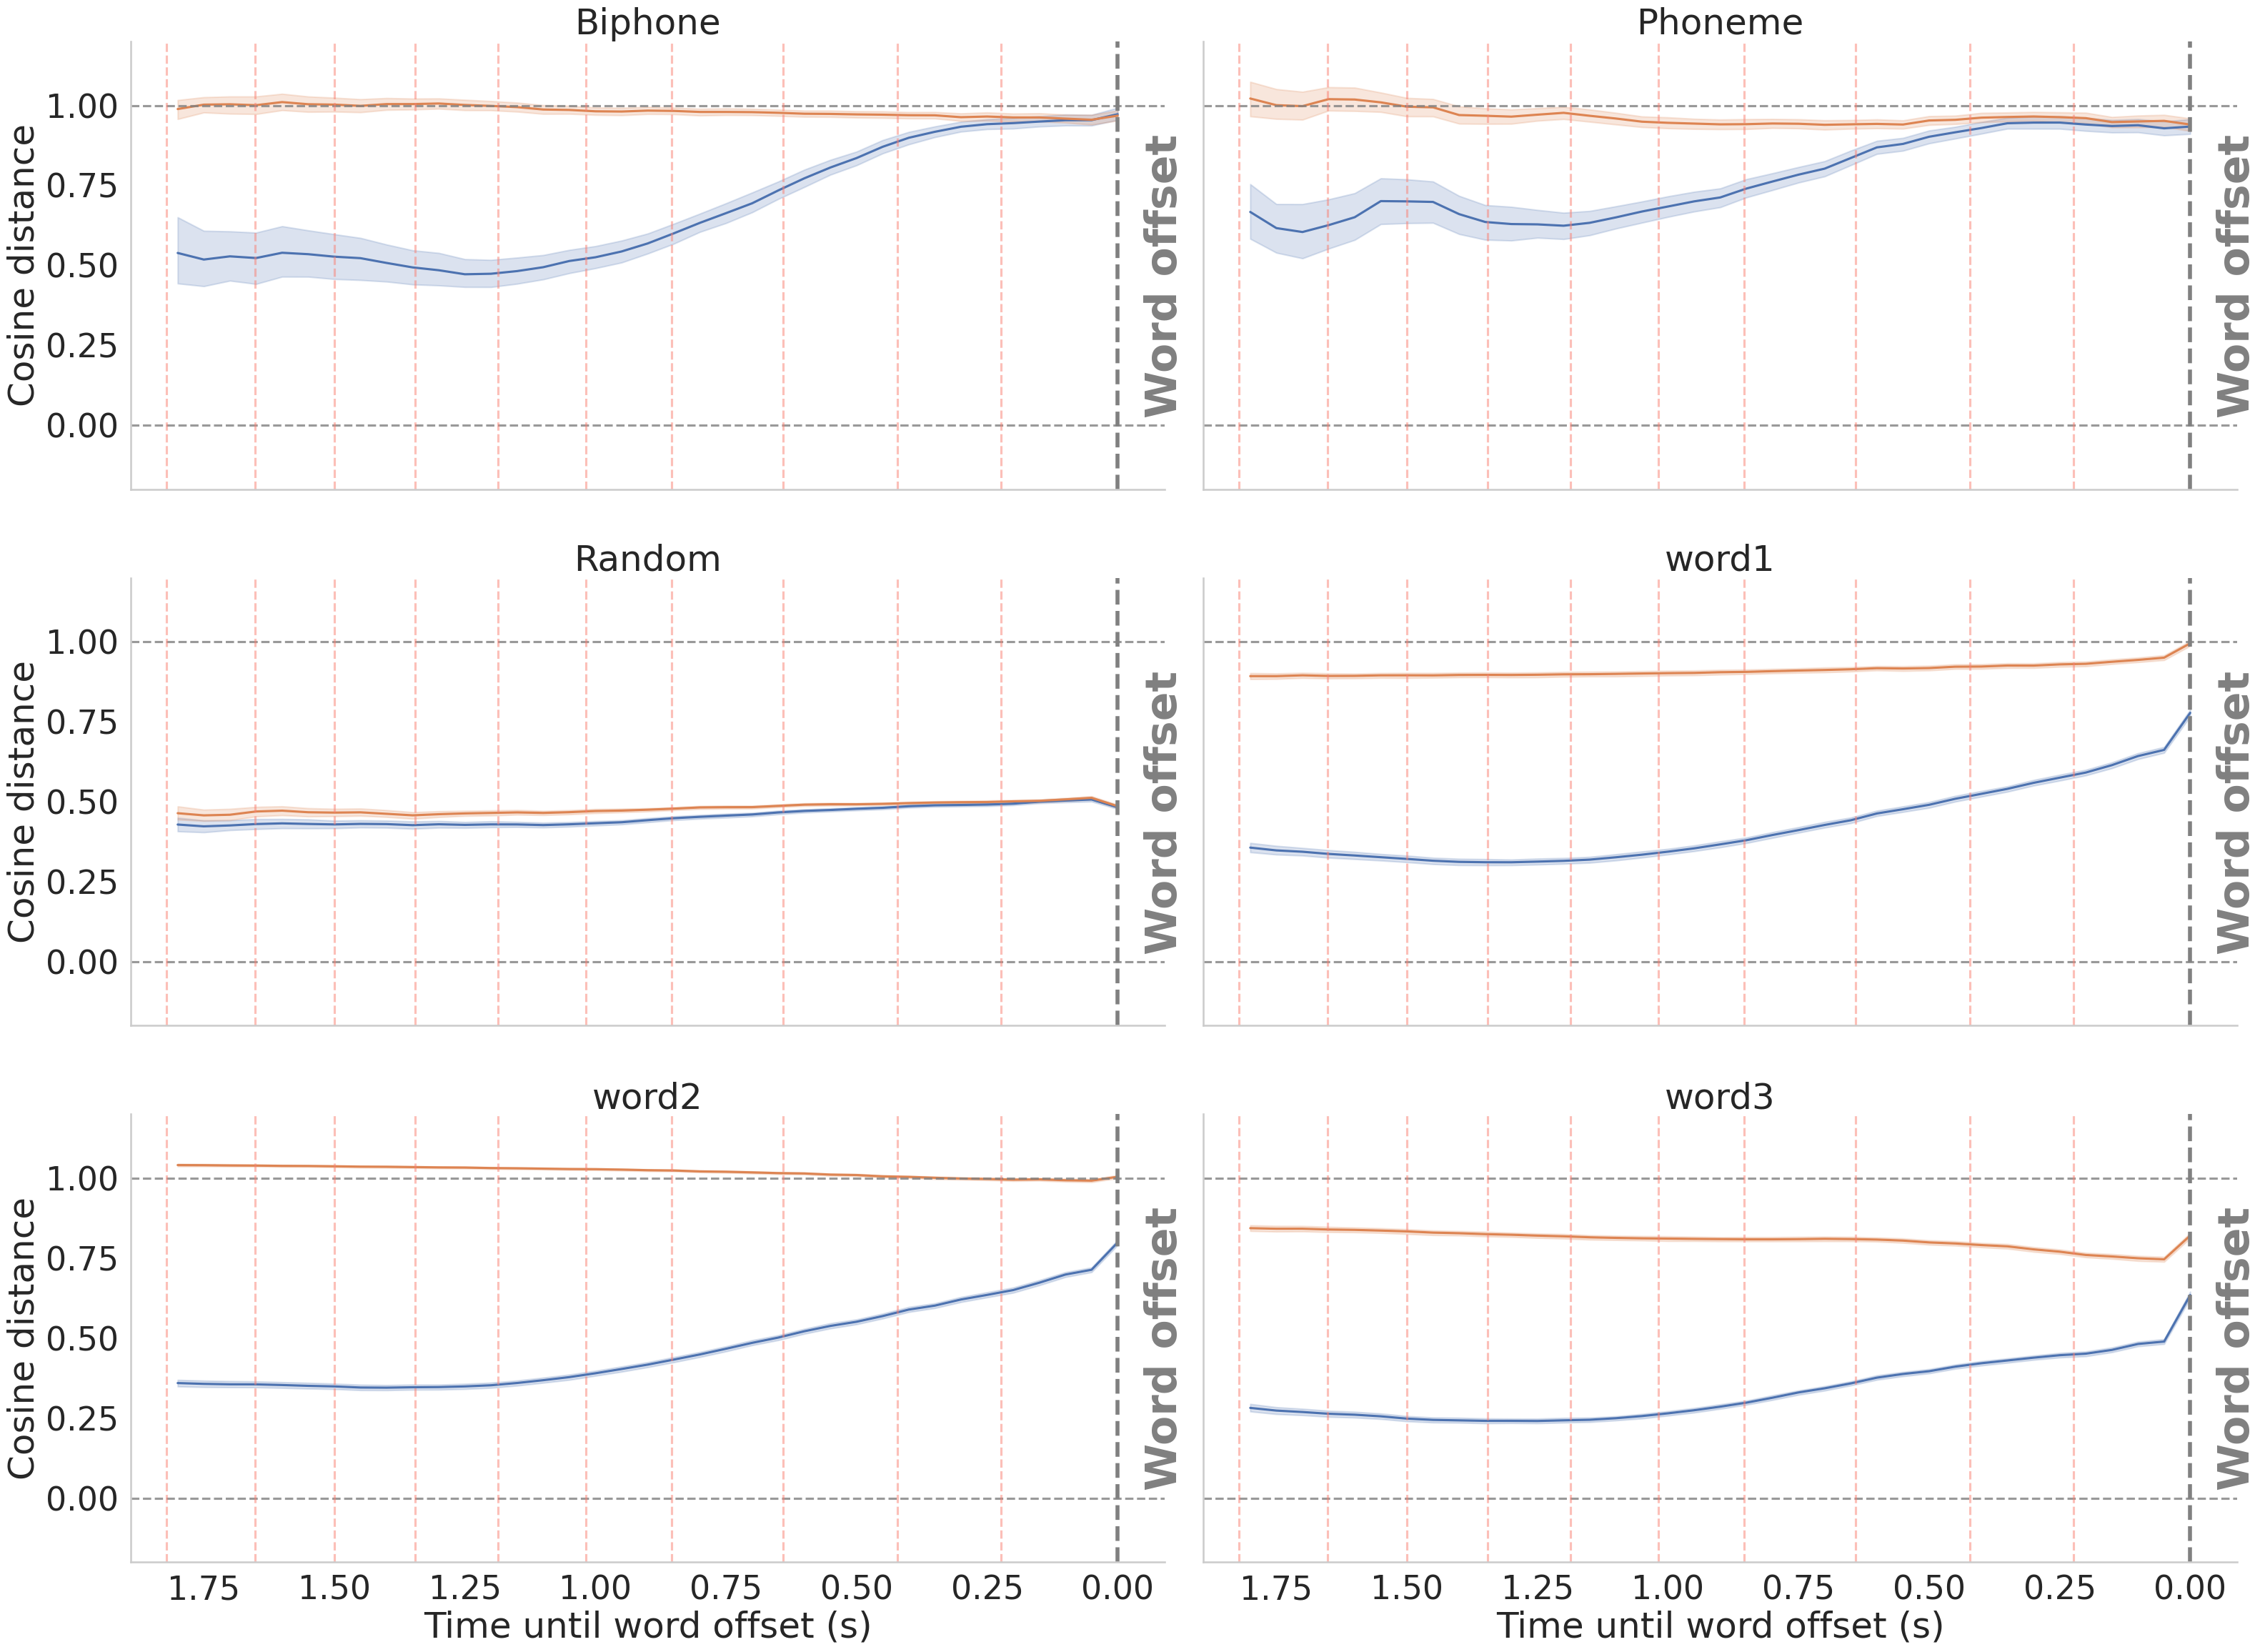

In [91]:
plot_coherence(word_onset_distance_align_offset_df, "word", col="name", alignment="offset", plot_phonemes=phoneme_in_word_reverse_mean_onsets)

### Grouped by offset

In [92]:
word_offset_distance_align_offset_df = load_grouped_distances("**/lexical_coherence/distances-grouped_offset_aligned_offset.csv")

/tmp/ipykernel_2321267/2152939426.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda xs: xs.dropna().groupby(["type"]).distance.count().min() < min_contrast_instances) \


In [93]:
# DEV
word_offset_distance_align_offset_df["time"] = (word_offset_distance_align_offset_df["frame"] - 1) / 20

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

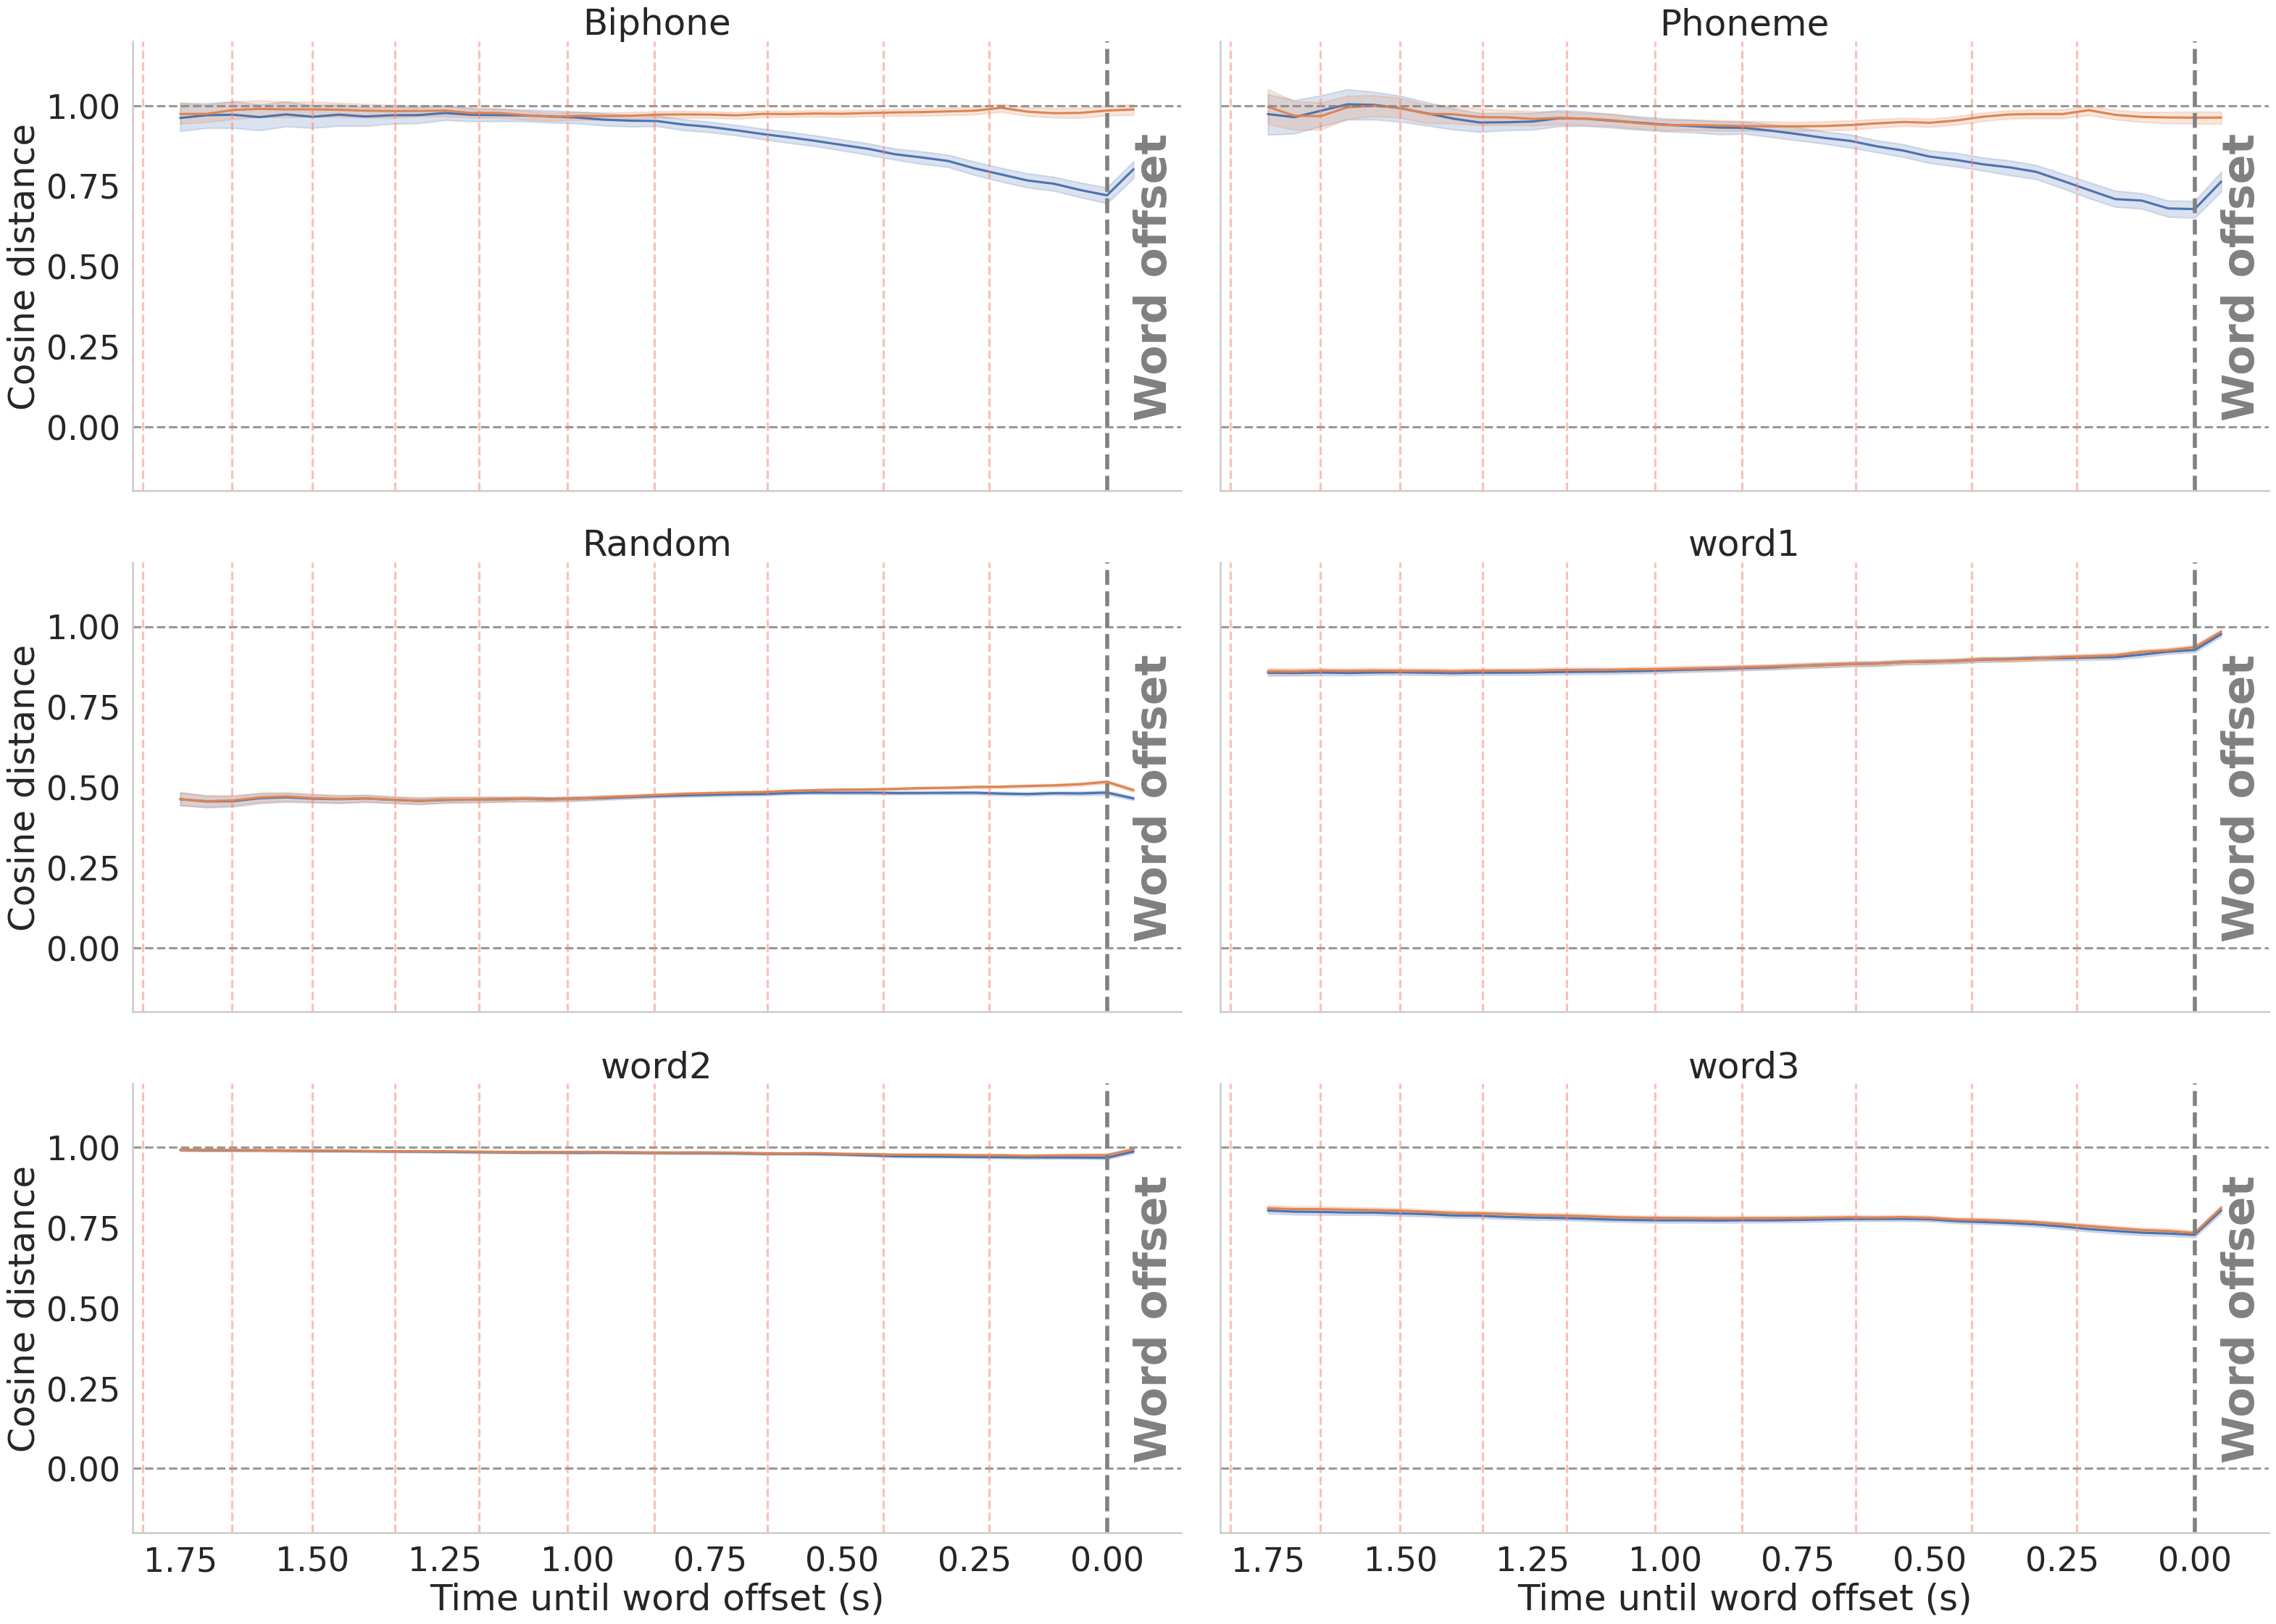

In [94]:
g = plot_coherence(word_offset_distance_align_offset_df, "word", col="name", alignment="offset",
                   plot_phonemes=phoneme_in_word_reverse_mean_onsets)

# adjust bottom of figure
g.fig.subplots_adjust(bottom=0.1)

# RSA analysis

## Phoneme level

In [95]:
phoneme_grouped_distances = pd.read_csv(f"outputs/notebooks/{plot_dataset}/{plot_base_model}/rnn_3-weightdecay0.01/phoneme_10frames/phoneme_coherence/grouped_distances.csv")

NameError: name 'plot_dataset' is not defined

In [ ]:
phoneme_rdm = phoneme_grouped_distances.pivot_table(index="p1", columns="p2", values="distance", aggfunc="mean")
phoneme_rdm.head()

p2  AA        AE        AH        AO        AW        AY         B        CH  \
p1                                                                             
AA NaN  0.066564  0.056450  0.048265  0.075348  0.057772  0.064896  0.332682   
AE NaN       NaN  0.060673  0.066163  0.066673  0.064041  0.069288  0.321639   
AH NaN       NaN       NaN  0.057842  0.059608  0.057948  0.051628  0.065170   
AO NaN       NaN       NaN       NaN  0.061215  0.045442  0.069603  0.337839   
AW NaN       NaN       NaN       NaN       NaN  0.073553  0.068352  0.343878   

p2         D        DH  ...        SH         T        TH        UH        UW  \
p1                      ...                                                     
AA  0.070008  0.066614  ...  0.294945  0.080114  0.246209  0.083886  0.119140   
AE  0.068625  0.066324  ...  0.390055  0.077625  0.246358  0.081352  0.092809   
AH  0.055432  0.046644  ...  0.064285  0.064008  0.064042  0.061935  0.066626   
AO  0.169739  0.071943  ...  0.296805  0.082675  0.249944  0.084134  0.118835   
AW  0.069610  0.067140  ...  0.390310  0.078802  0.247836  0.081017  0.104358   

p2         V         W         Y         Z        ZH  
p1                                                    
AA  0.147770  0.039301  0.048766  0.183592  0.215486  
AE  0.156802  0.047464  0.041226  0.181470  0.209929  
AH  0.054414  0.055401  0.055150  0.061033  0.065334  
AO  0.148718  0.035318  0.045277  0.187013  0.217795  
AW  0.153267  0.042710  0.044191  0.184021  0.213576  

[5 rows x 39 columns]

In [ ]:
for p1 in phoneme_rdm.index:
    for p2 in phoneme_rdm.columns:
        if np.isnan(phoneme_rdm.loc[p1, p2]):
            phoneme_rdm.loc[p1, p2] = phoneme_rdm.loc[p2, p1]

# Set diagonal to 0
np.fill_diagonal(phoneme_rdm.values, 0)

<Axes: xlabel='p2', ylabel='p1'>

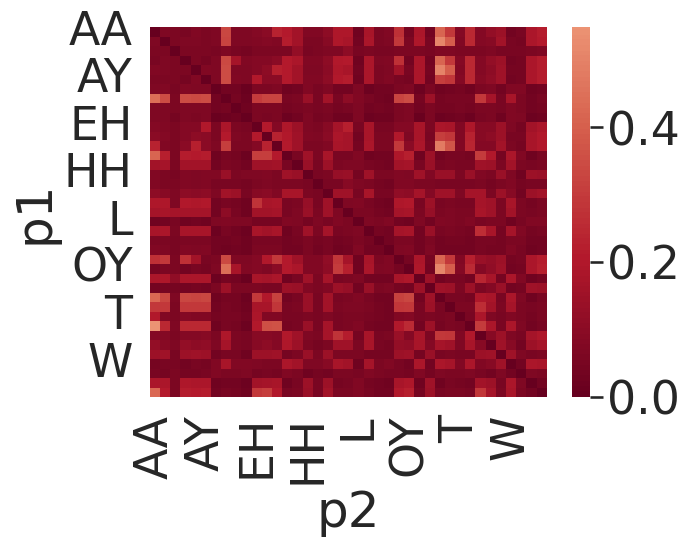

In [ ]:
sns.heatmap(phoneme_rdm, center=1, cmap="RdBu")

Text(1454.4166666666665, 0.5, '')

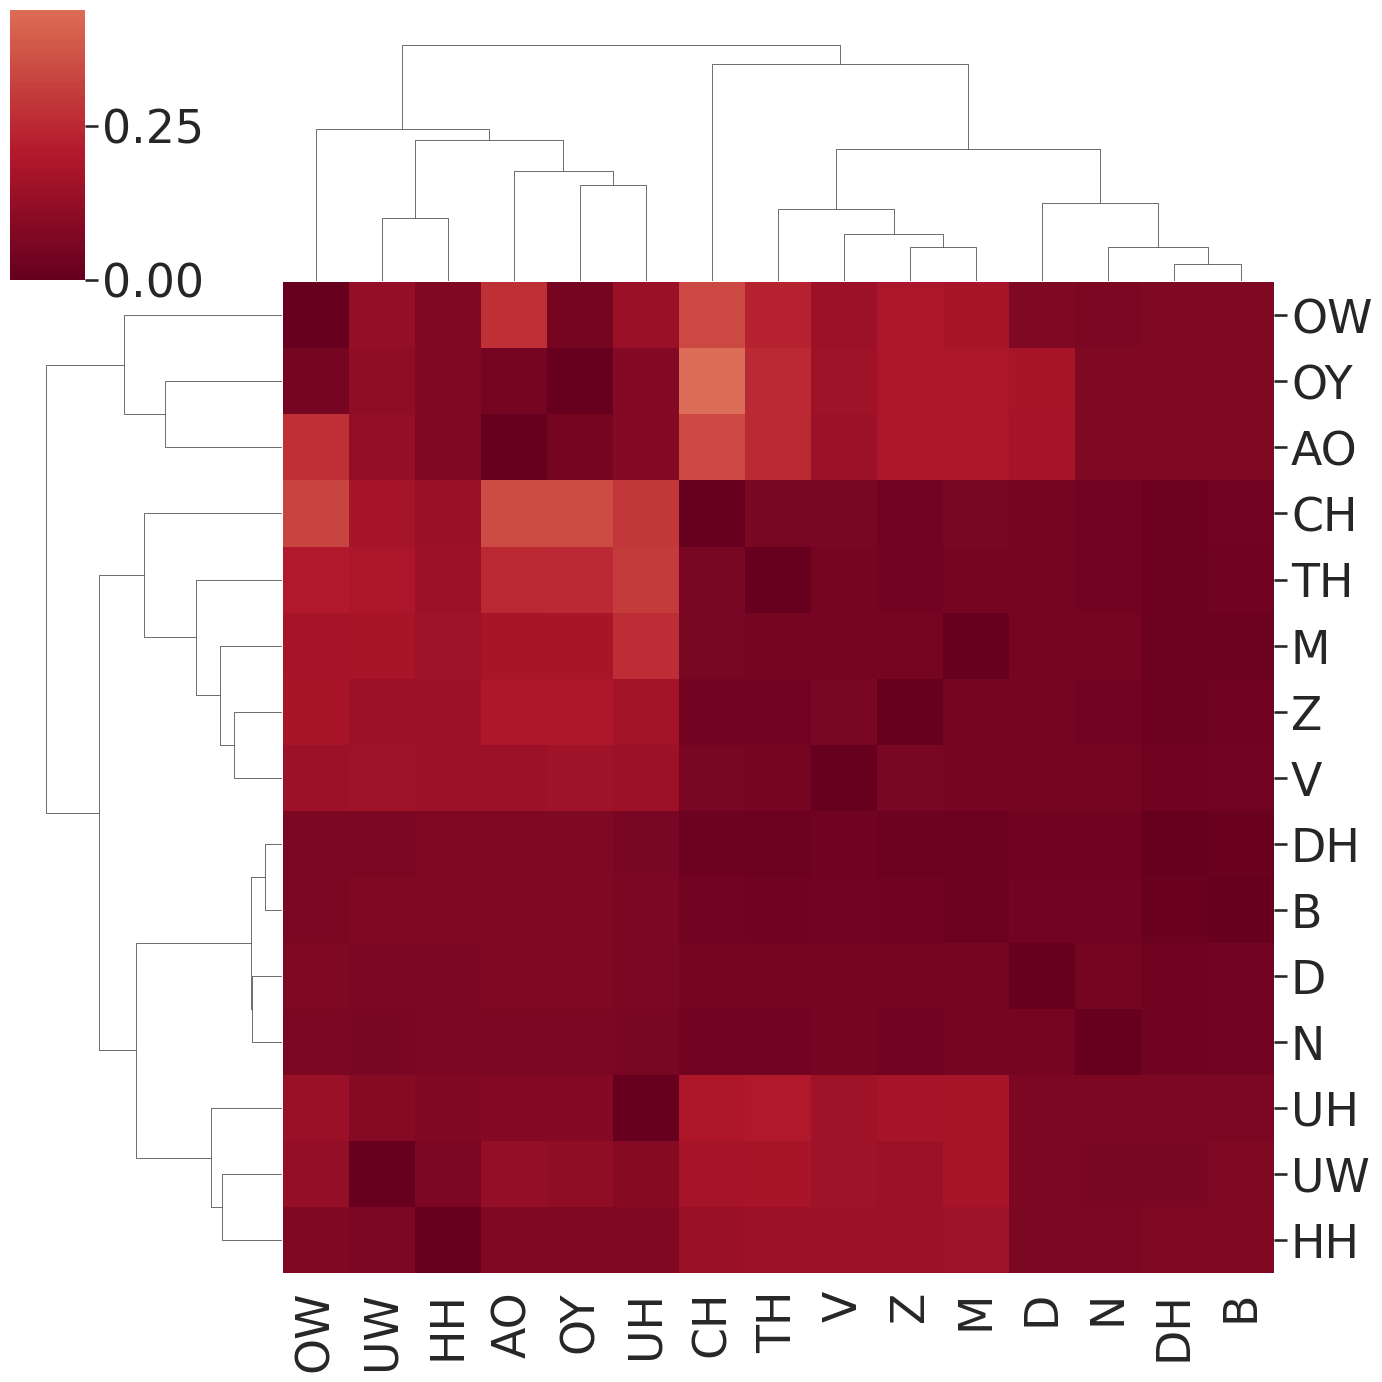

In [ ]:
# f, ax = plt.subplots(figsize=(18, 18))
subsample_phonemes = np.random.choice(len(phoneme_rdm), 15, replace=False)
phoneme_rdm_subsample = phoneme_rdm.iloc[subsample_phonemes, subsample_phonemes]
g = sns.clustermap(phoneme_rdm_subsample, center=1, cmap="RdBu", figsize=(15, 15), colors_ratio=0.1)
g.ax_heatmap.set_xlabel(None)
g.ax_heatmap.set_ylabel(None)

Text(2804.4166666666665, 0.5, '')

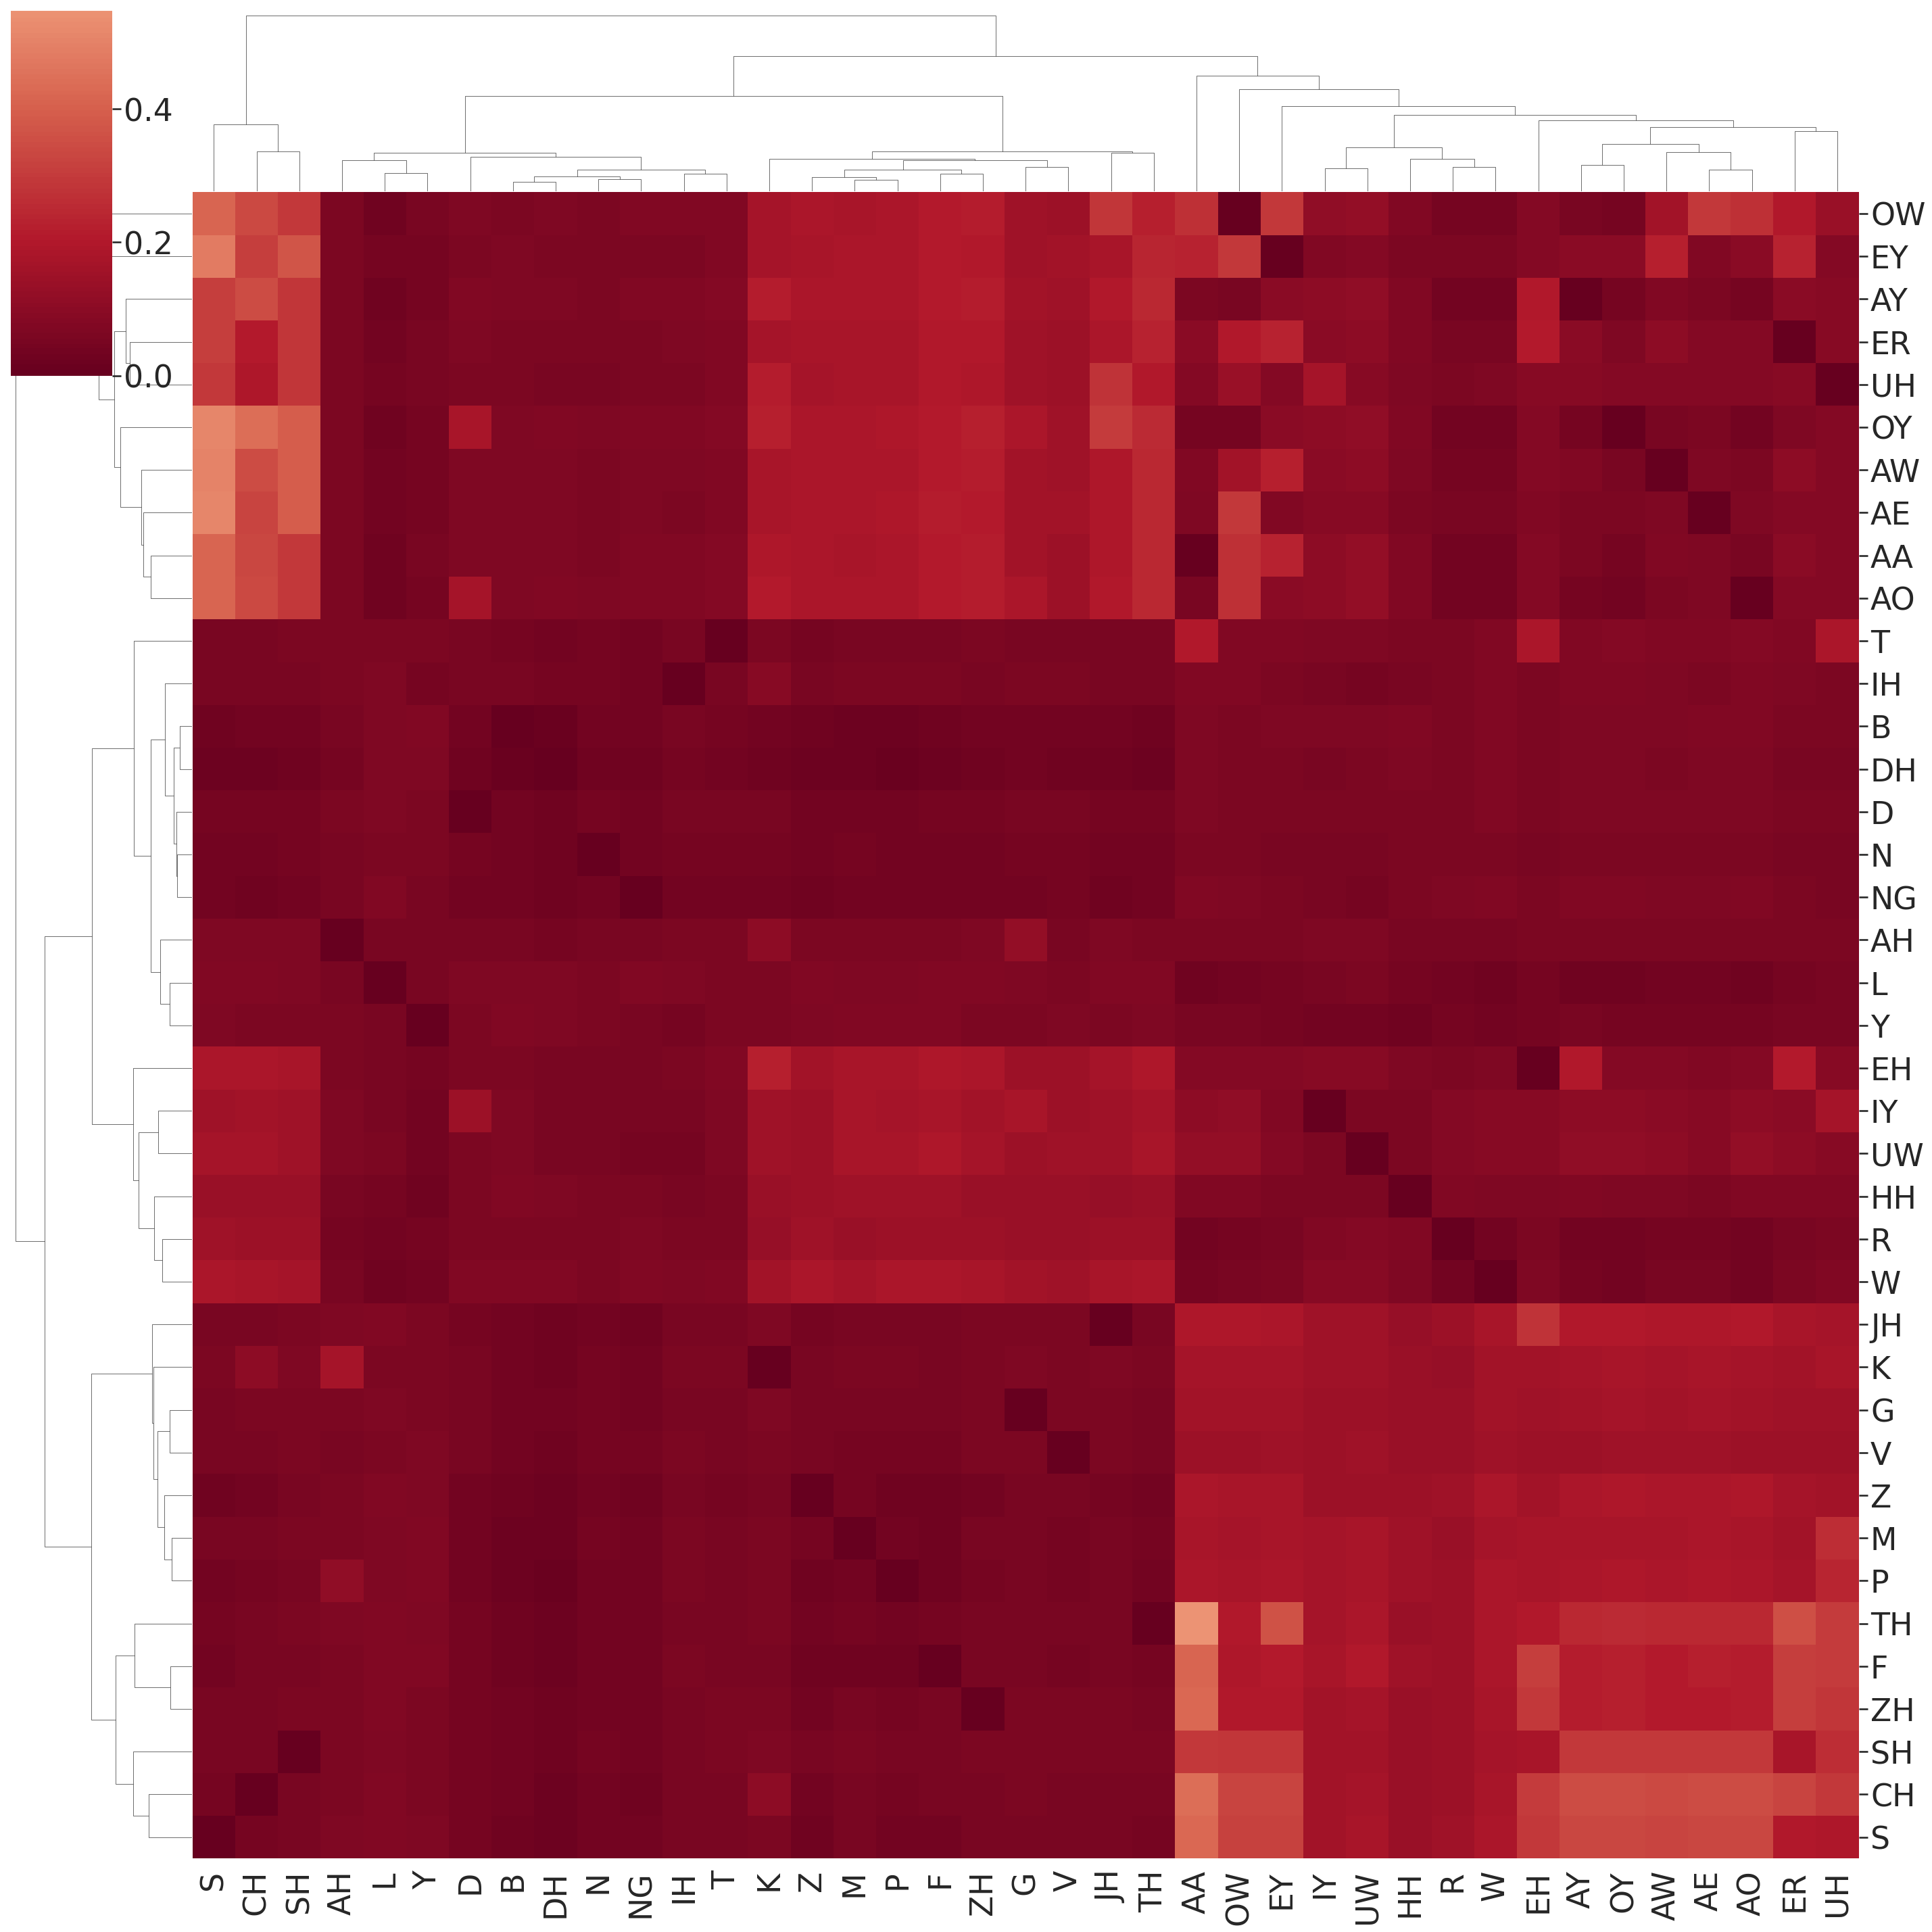

In [ ]:
# f, ax = plt.subplots(figsize=(18, 18))
g = sns.clustermap(phoneme_rdm, center=1, cmap="RdBu", figsize=(30, 30), colors_ratio=0.1, dendrogram_ratio=0.1)
g.ax_heatmap.set_xlabel(None)
g.ax_heatmap.set_ylabel(None)